In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from tqdm import tqdm
import seaborn as snb
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from utils.tools import *

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
import argparse
sys.argv = ['structure.py']
parser = argparse.ArgumentParser()
parser.add_argument('--Dim', type=int, default=3)
parser.add_argument('--Nodes_num', type=int, default=20)
parser.add_argument('--dt', type=float, default=0.01)
parser.add_argument('--Net', type=str, default='ER', help='BA, Di_BA or ER')
parser.add_argument('--Model', type=str, default='HR', help='Attractor')
parser.add_argument('--Time', type=int, default=500, help='T_time, default=10')
parser.add_argument('--Batch', type=int, default=256, help='BatchSize, default=4096')
parser.add_argument('--Hidden', type=int, default=50, help='Hidden Neurons')

args, unknown = parser.parse_known_args()

lam = None
tau_up = 0.999

In [4]:
data_path = 'data/'
save_path = 'Training_process/'

In [5]:
from utils.model import *
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
nodes_num = args.Nodes_num

aggr = 'add'
model = 'HR'
hidden = args.Hidden
n_f = 3
dt = args.dt
msg_dim = 1
dim = args.Dim

In [6]:
path = data_path+'timeseries.pickle'
with open(path, 'rb') as f:
    objectAij, series= pickle.load(f)
with open(save_path+'weights_tau0.999.pkl', 'rb') as f:
    weights_over_epcs = pickle.load(f)

epc = 999
weights_ind = weights_over_epcs[epc]
weights_ind = torch.Tensor(weights_ind)

In [7]:
len(np.where(objectAij==-1)[0]) # true inhibitory edges

58

In [8]:
len(np.where(objectAij==1)[0]) # true excitatory edges

42

In [9]:
import torch
import torch.nn.functional as F
    
nodes_num = args.Nodes_num
Accuracy = []
threshold = 0.5

def get_binary_weight_error(weights_over_epcs,threshold):
    for w in range(len(weights_over_epcs)):
        weights_ind = weights_over_epcs[w]
        weights_ind = torch.Tensor(weights_ind)
        Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
        Gweights = ((-1)*Gweights[:,0]+Gweights[:,1])
        Gweights = Gweights.view(-1,1).cpu()
        bestWei = Gweights.detach().numpy()
        
        bi_bestWei = bestWei.copy()
        bi_bestWei = np.where(bi_bestWei<-0.5,-1,bi_bestWei)
        bi_bestWei = np.where(bi_bestWei>0.5,1,bi_bestWei)
        bi_bestWei = np.where((bi_bestWei>-0.5) & (bi_bestWei<0.5),0,bi_bestWei)

        bi_Stru = np.zeros((nodes_num, nodes_num))
        mask = np.ones((nodes_num, nodes_num), dtype=bool)
        np.fill_diagonal(mask, 0)
        bi_Stru[mask] = bi_bestWei.squeeze()

        bi_bestWei_alllinks = bi_Stru.reshape(-1,1)
        error = np.sum(np.abs(bi_bestWei_alllinks - objectAij.reshape(-1,1)))/(nodes_num*(nodes_num-1))
        Accuracy.append(1-error)
    return Accuracy

Accu = get_binary_weight_error(weights_over_epcs,0.5)

triple classificatio: calculate precision and recall value for each class, then calculate $f1-score=\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}$

In [10]:
from sklearn.metrics import f1_score
inhedge = []
exiedge = []
noedge = []

def get_weight_f1score(weights_over_epcs,threshold):
    for w in range(len(weights_over_epcs)):
        weights_ind = weights_over_epcs[w]
        weights_ind = torch.Tensor(weights_ind)
        Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
        Gweights = ((-1)*Gweights[:,0]+Gweights[:,1])
        Gweights = Gweights.view(-1,1).cpu()
        bestWei = Gweights.detach().numpy()
        
        bi_bestWei = bestWei.copy()
        bi_bestWei = np.where(bi_bestWei<-threshold,-1,bi_bestWei)
        bi_bestWei = np.where(bi_bestWei>threshold,1,bi_bestWei)
        bi_bestWei = np.where((bi_bestWei>-threshold) & (bi_bestWei<threshold),0,bi_bestWei)

        bi_Stru = np.zeros((nodes_num, nodes_num))
        mask = np.ones((nodes_num, nodes_num), dtype=bool)
        np.fill_diagonal(mask, 0)
        bi_Stru[mask] = bi_bestWei.squeeze()

        bi_bestWei_alllinks = bi_Stru.reshape(-1,1)
        nscore, zscore, pscore = f1_score(objectAij.reshape(-1,1), bi_bestWei_alllinks, average=None)
        inhedge.append(nscore)
        noedge.append(zscore)
        exiedge.append(pscore)
    return inhedge, noedge, exiedge
inhedge, noedge, exiedge = get_weight_f1score(weights_over_epcs,0.5)

(2000, 3)


/tmp/ipykernel_85287/1127355613.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Evaluation['epoch'] = np.arange(1, len(Evaluation)+1)
/tmp/ipykernel_85287/1127355613.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Evaluation['x_bin'] = pd.cut(Evaluation['epoch'], bins=25)
/tmp/ipykernel_85287/1127355613.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt

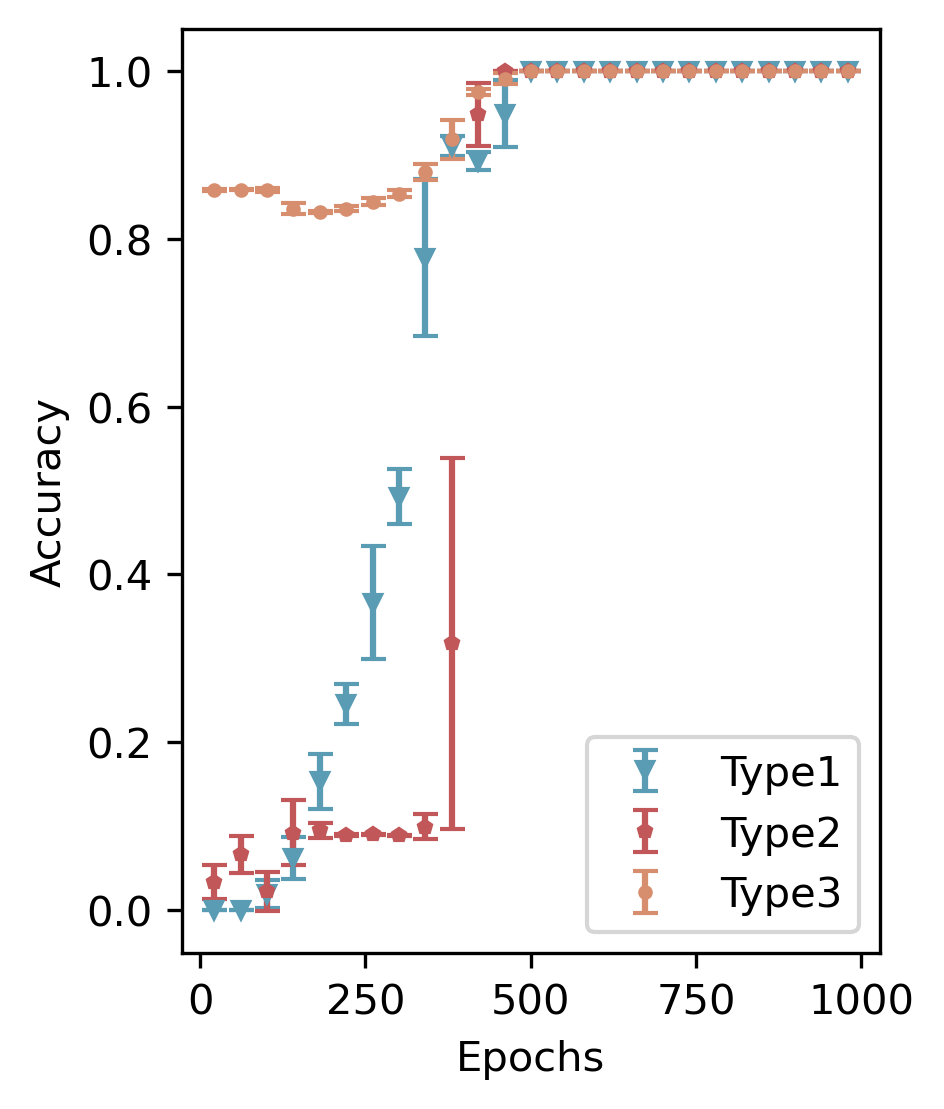

In [11]:
import matplotlib.pyplot as plt
import numpy as np

Eval = pd.DataFrame()   
Eval['inhedge_accu'] = inhedge
Eval['noedge_accu'] = noedge
Eval['exiedge_accu'] = exiedge
print(Eval.shape)
Evaluation = Eval[0:1000]
Evaluation['epoch'] = np.arange(1, len(Evaluation)+1)
Evaluation['x_bin'] = pd.cut(Evaluation['epoch'], bins=25)

inhedge_stats = Evaluation.groupby('x_bin')['inhedge_accu'].agg(['mean', 'std'])
inhedge_centers = inhedge_stats.index.map(lambda x: x.mid).astype(float)
exiedge_stats = Evaluation.groupby('x_bin')['exiedge_accu'].agg(['mean', 'std'])
exiedge_centers = exiedge_stats.index.map(lambda x: x.mid).astype(float)
noedge_stats = Evaluation.groupby('x_bin')['noedge_accu'].agg(['mean', 'std'])
noedge_centers = noedge_stats.index.map(lambda x: x.mid).astype(float)

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(3,4))

# palette = ['#C25759','#599CB4']
plt.errorbar(x=inhedge_centers, y=inhedge_stats['mean'], yerr=inhedge_stats['std'], fmt='v', capsize=3,markersize=4,label='Type1',color='#599CB4')
plt.errorbar(x=exiedge_centers, y=exiedge_stats['mean'], yerr=exiedge_stats['std'], fmt='p', capsize=3,markersize=3,label='Type2',color='#C25759')
plt.errorbar(x=noedge_centers, y=noedge_stats['mean'], yerr=noedge_stats['std'], fmt='o', capsize=3,markersize=2.5,label='Type3',color='#D78E6E')
plt.legend(facecolor='white',loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.grid(axis='y',ls='--',color='lightgray', alpha=0.6)
# plt.savefig('figure2/v6/Accuracy_over_epoch_red_green.pdf')
plt.show()

### read weights results no comparison (did not identify each type)

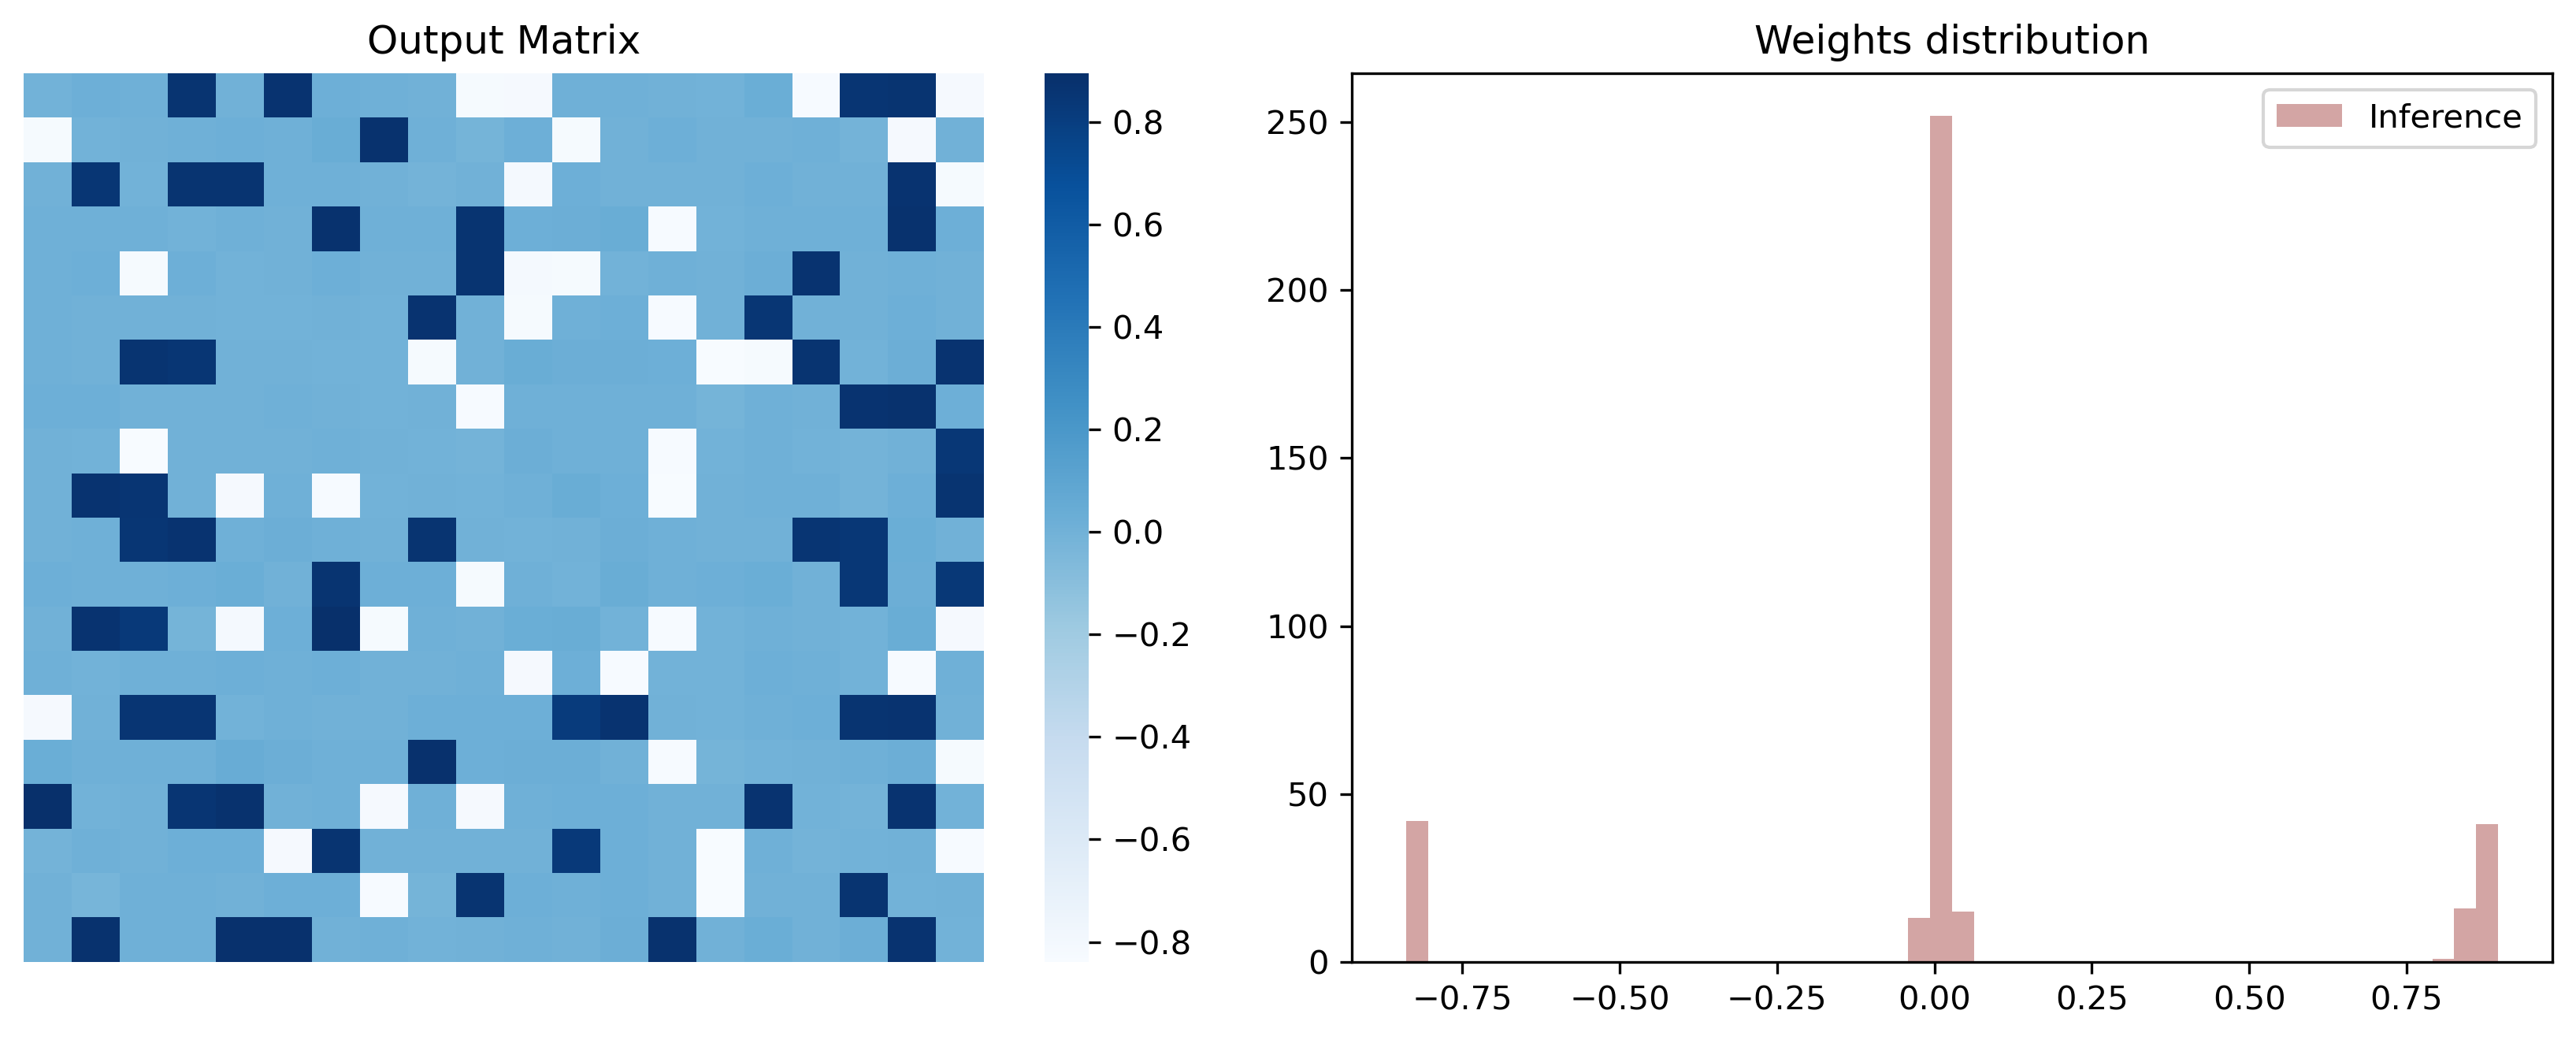

In [12]:
Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
Gweights = (1*Gweights[:,0])+((-1)*Gweights[:,1]) #Gweights[:,0] is excitatory, Gweights[:,1] is inhibitory
Gweights = Gweights.view(-1,1).cpu()
# Gweights.cpu
bestWei = Gweights.detach().numpy()

nodes_num = args.Nodes_num
edge_num = nodes_num*(nodes_num-1)
bestWei = bestWei[:edge_num]

Stru = np.zeros((nodes_num, nodes_num))
mask = np.ones((nodes_num, nodes_num), dtype=bool)
np.fill_diagonal(mask, 0)
Stru[mask] = bestWei.squeeze()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))
snb.heatmap(Stru, cmap='Blues', ax=ax1)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Output Matrix')
plt.hist(bestWei,bins=50,alpha=0.7, color='#C17F7E', label='Inference')
plt.legend()
ax2.set_title('Weights distribution')

# plt.savefig('figure2/HR20nodes_inference_results.pdf')

plt.tight_layout()
plt.show()

In [13]:
bistru = Stru.copy()
bistru = np.where(bistru<-0.5,-1,bistru)
bistru = np.where(bistru>0.4,1,bistru)
bistru = np.where((bistru>-0.5) & (bistru<0.4),0,bistru)
print(len(np.where(bistru==1)[0]))
print(len(np.where(bistru==-1)[0]))
print(len(np.where(bistru==0)[0]))

58
42
300


### weights distribution evolute over epochs

In [14]:
weights_chosen = []
epc_chosen = [1,100,300,400,600,1000]
epcstring = ['epoch=1','epoch=100','epoch=300','epoch=400','epoch=600','epoch=1000']
for e in epc_chosen:
    weights_ind = weights_over_epcs[e-1]
    weights_ind = torch.Tensor(weights_ind)
    Gweights = F.softmax(weights_ind/(0.999**(e-1)),dim=1)
    Gweights = Gweights[:,0].view(-1,1)
    Gweights.cpu
    bestWei = Gweights.detach().numpy()
    bestWei = bestWei[:edge_num]
    weights_chosen.extend(bestWei)

print(len(weights_chosen))
print('number of edges:',int(len(weights_chosen)/len(epc_chosen)))

weights_chosen = pd.DataFrame(np.array(weights_chosen),columns=['weights'])
weights_chosen['epoch'] = np.repeat(epcstring,int(len(weights_chosen)/len(epc_chosen)))
print(weights_chosen.shape)

2280
number of edges: 380
(2280, 2)


#### ridgeline plots

380
number of edges: 13
(380, 29)


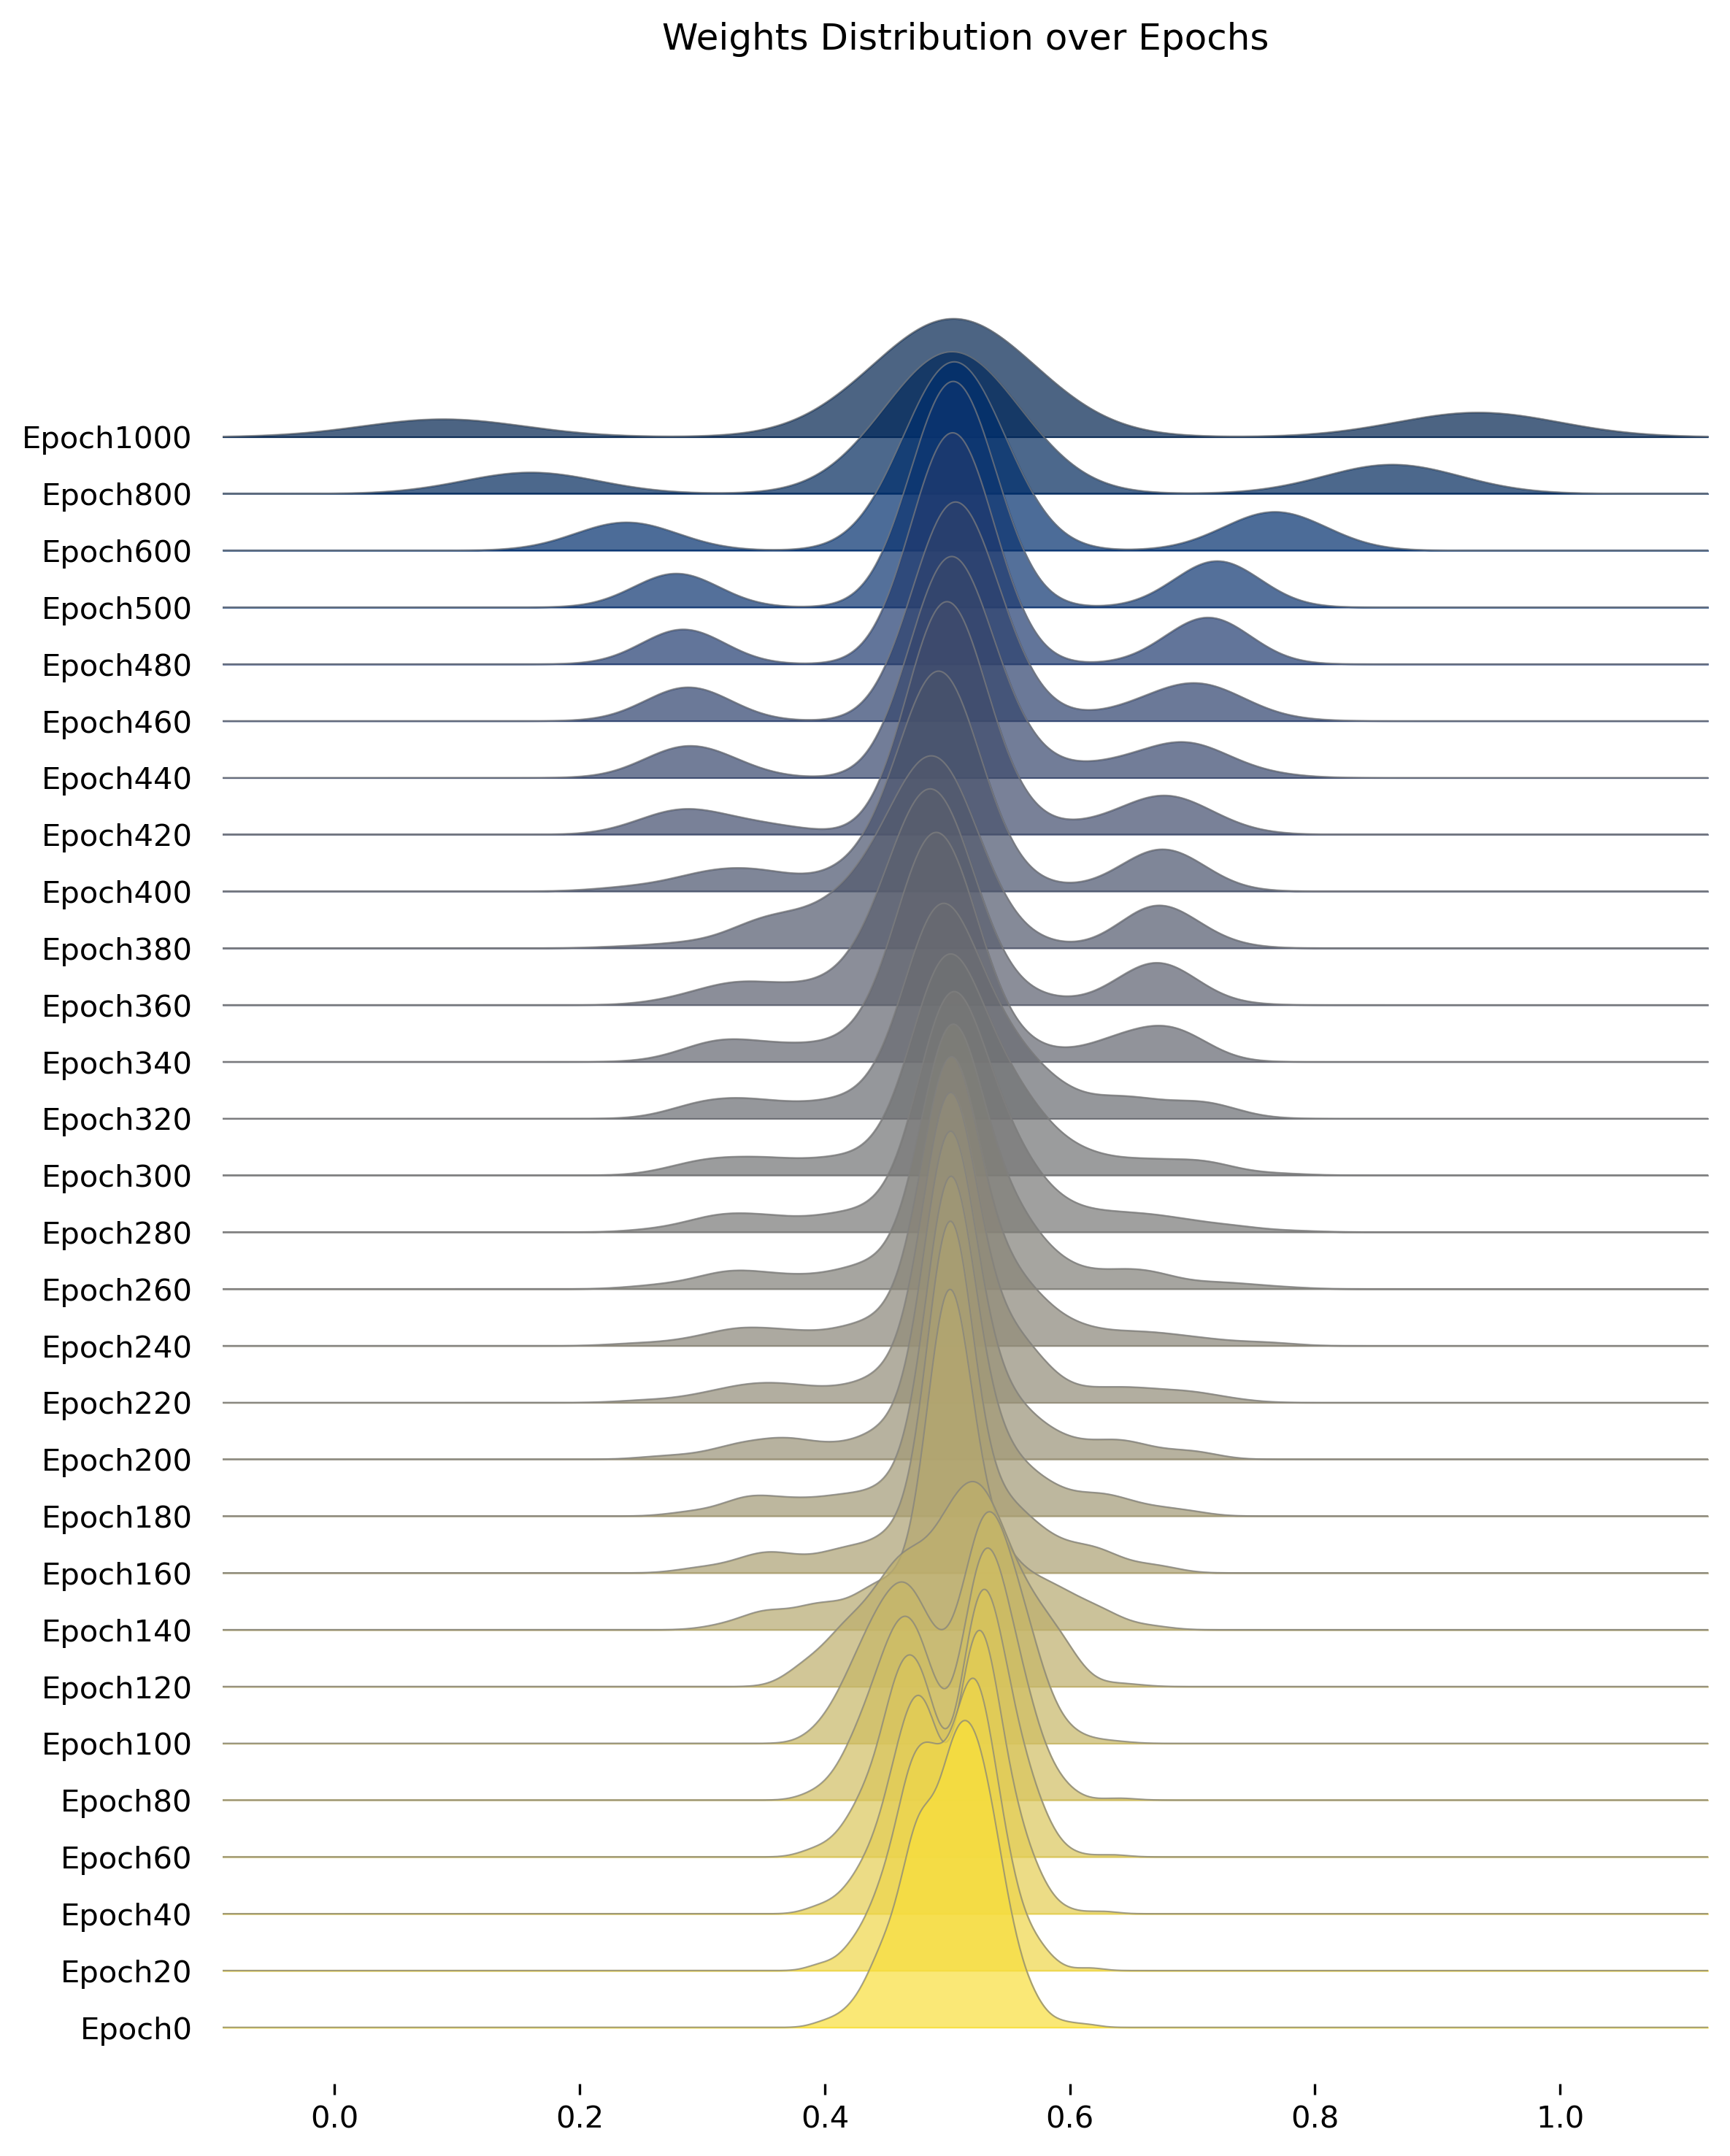

In [15]:
import pandas as pd
import numpy as np
import joypy
import matplotlib.pyplot as plt
nodes_num = 20
edge_num = nodes_num*(nodes_num-1)
weights_chosen = pd.DataFrame()
epc_chosen = np.arange(1,502,20)
epc_chosen = epc_chosen.tolist()
epc_chosen.append(601)
epc_chosen.append(801)
epc_chosen.append(1001)
epc_chosen.reverse()
# epcstring = ['epoch=1','epoch=100','epoch=300','epoch=400','epoch=600','epoch=1000']
for e in epc_chosen:
    weights_ind = weights_over_epcs[e-1]
    weights_ind = torch.Tensor(weights_ind)
    Gweights = F.softmax(weights_ind/(0.999**(e-1)),dim=1)
    Gweights = Gweights[:,0].view(-1,1)
    Gweights.cpu
    bestWei = Gweights.detach().numpy()
    bestWei = bestWei[:edge_num]
    weights_chosen[f'Epoch{e-1}'] = np.array(bestWei).reshape(-1)
    # weights_chosen.extend(bestWei)

print(len(weights_chosen))
print('number of edges:',int(len(weights_chosen)/len(epc_chosen)))
print(weights_chosen.shape)

plt.rcParams['figure.dpi']=300
fig, axes = joypy.joyplot(
    weights_chosen,
    figsize=(8, 10), 
    overlap=2.5,
    colormap=plt.cm.cividis,
    title='Weights Distribution over Epochs', 
    linecolor='grey',
    linewidth=0.5,
    alpha=0.7,
)
# plt.savefig('figure2/v3/weights_distribution_over_epochs_less_reverse.pdf')
plt.show()


In [16]:
# Parameter setting
Trial = 1
Dimension = 3
dt = 0.01
Time = 500
nodes_num = 20
batch = args.Batch
Net = 'ER'

path = data_path + 'timeseries.pickle'
with open(path, 'rb') as f:
    objectAij, series= pickle.load(f)

series = series.reshape(-1, nodes_num, Dimension)
print(series.shape)
goal_data = series[1:-1,:,0:Dimension]
mapping_data = series[0:-2,:,0:Dimension]
print(goal_data.shape==mapping_data.shape)
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

(50000, 20, 3)
True


In [17]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [18]:
def get_edge_index(Adj): #target to source (i2j)
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

initialA = np.ones((nodes_num,nodes_num)) # fully connected
np.fill_diagonal(initialA,0) # delete diagonal links
edge_index = get_edge_index(initialA)
index = [1,0]
edge_index_j2i = edge_index[index]

aggr = 'add'
model = 'HR'
hidden = 50
n_f = Dimension
msg_dim = 1
dim = Dimension
edge_num = edge_index_j2i.shape[1]
tau = 1
lam = None


### load recorded models

In [19]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [20]:
recorded_models = torch.load(save_path+'recorded_models.pt')
print(len(recorded_models))

np.random.seed(65)

hidden = 50
n_f = Dimension
msg_dim = 1
dim = Dimension
edge_num = edge_index_j2i.shape[1]
tau = 1
lam = None
Dyn = Get_sign_MP_ori(n_f, msg_dim, dim, dt, edge_num, tau=tau, lam=lam, aggr=aggr, hidden=hidden).to(device)
Dyn.load_state_dict(recorded_models[-1])

/tmp/ipykernel_85287/1436102557.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recorded_models = torch.load(save_path+'recorded_models.pt')


2000


<All keys matched successfully>

In [21]:
# fully connected
np.random.seed(2044)
test_idxes = np.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index_j2i,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [22]:
def get_messages_ori(tDyn, dim, msg_dim, loader):

    def get_message_info(tmp):
        tDyn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source
        s1 = s1[:,0]
        s2 = tmp.x[tmp.edge_index[1]] #target
        s2 = s2[:,0]
        Tmp = torch.cat([s2, s1]) # tmp --> xi,xj
        Tmp = Tmp.reshape(2,-1)
        Tmp = Tmp.t()# tmp has shape [E, 2 * in_channels]

        Gweights = F.softmax(tDyn.weights/(0.999**epc),dim=1)
        Gweights = (1*Gweights[:,0])+((-1)*Gweights[:,1]) #Gweights[:,0] is excitatory, Gweights[:,1] is inhibitory
        Gweights = Gweights.view(-1,1)
        Len = int(s1.shape[0])/int(Gweights.shape[0])
        T = Gweights.repeat(int(Len),1)
        print(T.shape)
        T_excit = torch.where(T>0,T,0)
        T_inh = torch.where(T<0,-T,0)

        tmpT = torch.cat([Tmp,T],dim=1)
        tmpT = tmpT.to(torch.float32)

        m12_excit = tDyn.msg_fnc_excit(Tmp)
        m12_inh = tDyn.msg_fnc_inh(Tmp)
        m12 = m12_excit*T_excit+m12_inh*T_inh

        all_messages = torch.cat((
            tmpT, m12_excit, m12_inh,
             m12), dim=1)
        if dim == 1:
            columns = [elem%(k) for k in range(1,3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['type1']
            columns += ['type2']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['type1']
            columns += ['type2']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['type1']
            columns += ['type2']
            columns += ['e%d'%(k,) for k in range(msg_dim)]

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [23]:
def get_selfDynamics(ogn, dim, loader):
    def get_selfDynamics_info(tmp):
        
        ogn.cpu()
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x), dim=1)
            columns = ['x','s1']
            
        if dim==2:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y), dim=1)
            columns = ['x','y','s1','s2']
        if dim==3:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_z = ogn.node_fnc_z(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y,self_dyn_z), dim=1)
            columns = ['x','y','z','s1','s2','s3']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(loader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info        

In [24]:
device = torch.device('cpu')

In [25]:
msgs = get_messages_ori(Dyn, dim=Dimension, msg_dim=1, loader=newtestloader)
selfdyn = get_selfDynamics(Dyn,dim=Dimension, loader=newtestloader)

torch.Size([380000, 1])


In [26]:
msgs

x1        x2             T     type1     type2            e0
0      -0.764064  0.721107  1.712084e-03 -0.005628  0.024921 -9.635643e-06
1      -0.764064  1.075585  2.262950e-03 -0.070020  0.277363 -1.584512e-04
2      -0.764064 -1.071068  9.584781e-01 -0.000020  0.000019 -1.903745e-05
3      -0.764064 -0.855869 -1.974404e-04 -0.000020  0.000019  3.807433e-09
4      -0.764064 -1.319773  8.088563e-01 -0.000020  0.000019 -1.606564e-05
...          ...       ...           ...       ...       ...           ...
379995 -0.918851 -0.683670  4.200339e-04 -0.000020  0.000019 -8.342785e-09
379996 -0.918851 -0.930210  2.980232e-08 -0.000020  0.000019 -5.919388e-13
379997 -0.918851 -0.974116 -2.692938e-04 -0.000020  0.000019  5.193052e-09
379998 -0.918851  1.762339  6.026924e-04 -0.075702  0.428967 -4.562495e-05
379999 -0.918851 -0.813934  8.883071e-01 -0.000020  0.000019 -1.764371e-05

[380000 rows x 6 columns]

In [27]:
# x1 (x_i) is target, x2 (x_j) is source 
msg_type2 = msgs[msgs['T'] < -0.5] 
x_i = msg_type2['x1'].values
x_j = msg_type2['x2'].values
G_type22 = msg_type2.iloc[:,-2].values

if np.sum(G_type22 > 0):
    coup_value_exc = 0.15*(2-x_i)/(1+np.exp(-10*(x_j-1))) 
    print("G_type22 values are excitary.")
else:
    coup_value_inh = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) 
    print("G_type22 values are inhibitory.")

msg_type1 = msgs[msgs['T'] > 0.5 ]
x_i = msg_type1['x1'].values
x_j = msg_type1['x2'].values
G_type11 = msg_type1.iloc[:,-3].values
if np.sum(G_type11 < 0):
    coup_value_inh = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) # inhibitory
    print("G_type11 values are inhibitory.")
else:
    coup_value_exc = 0.15*(2-x_i)/(1+np.exp(-10*(x_j-1))) # excitary
    print("G_type11 values are excitary.")

G_type22 values are excitary.
G_type11 values are inhibitory.


In [28]:
np.random.seed(2044)
num = 1000
# index = np.random.randint(0, 40000, num)
index = np.arange(0, num,1)

Text(0, 0.5, 'Inferred type2 interactions')

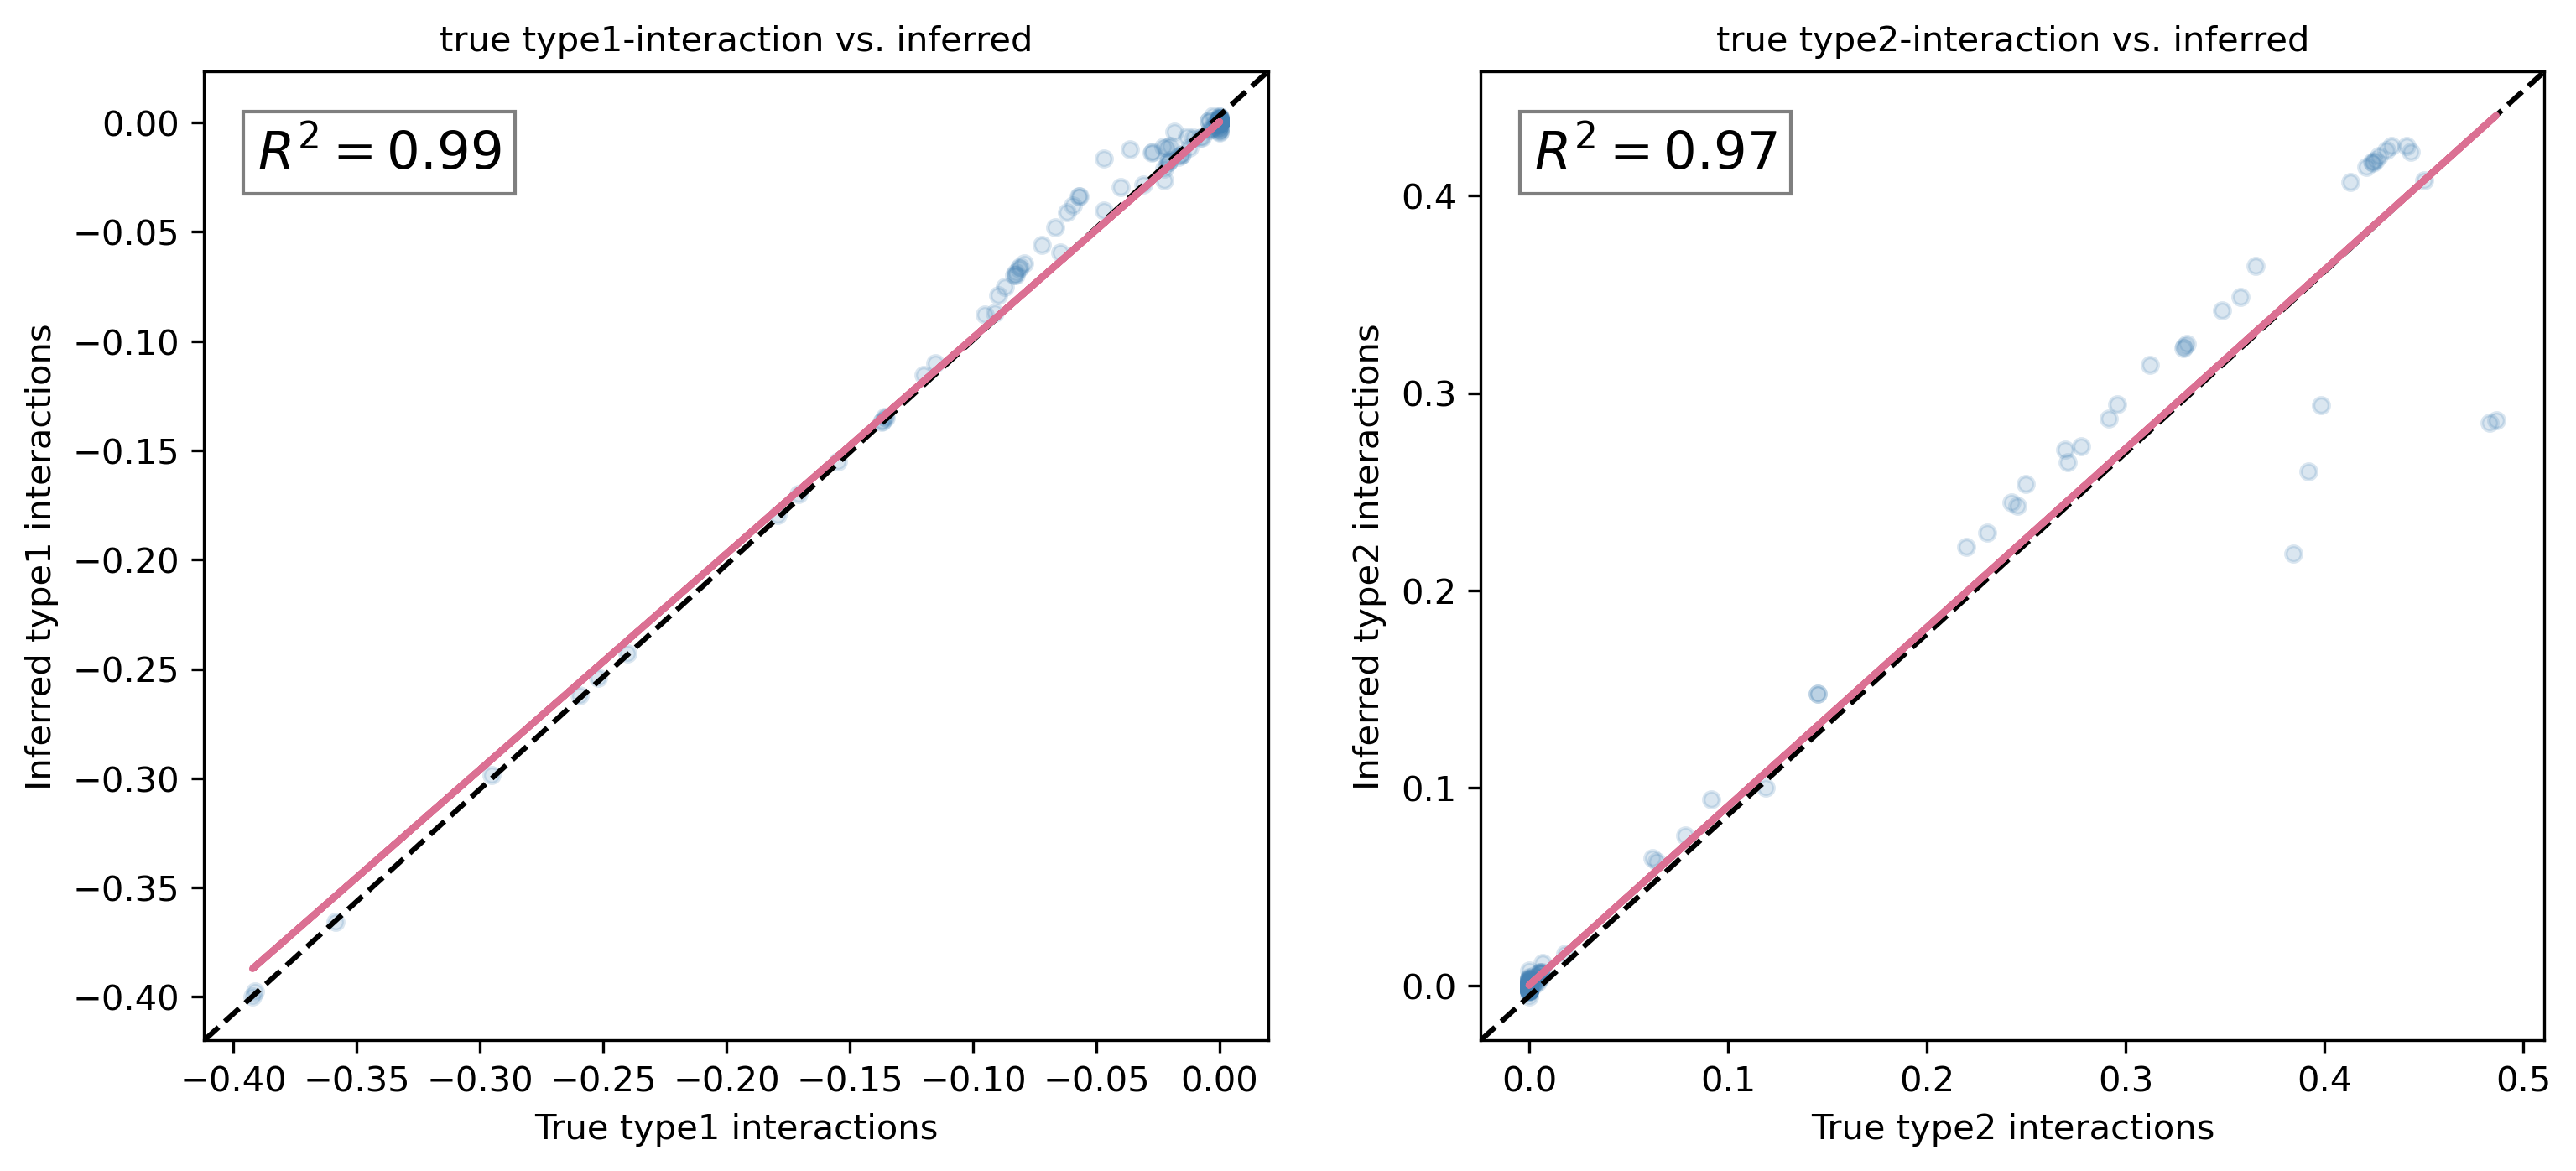

In [29]:
G_type2 = G_type22[index]
G_type1 = G_type11[index]
coup_value_inh = coup_value_inh[index]
coup_value_exc = coup_value_exc[index]
import matplotlib as mpl
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,2,1)
plt.title("true type1-interaction vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(coup_value_inh,G_type1,s=20,c ='steelblue', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(coup_value_inh,G_type1,1)
fx = np.poly1d(parameterx)
ax1.plot(coup_value_inh,fx(coup_value_inh),c='palevioletred',lw=2)
corrx = np.corrcoef(coup_value_inh,G_type1)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True type1 interactions")
plt.ylabel("Inferred type1 interactions")

ax2 = fig.add_subplot(1,2,2)
plt.title("true type2-interaction vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(coup_value_exc,G_type2,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(coup_value_exc,G_type2,1)
fy = np.poly1d(parametery)
ax2.plot(coup_value_exc,fy(coup_value_exc),c='palevioletred',lw=2)
corry = np.corrcoef(coup_value_exc,G_type2)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True type2 interactions")
plt.ylabel("Inferred type2 interactions")
# plt.savefig('retrain_inference_results_lr5e-4.pdf')

In [30]:
import pandas as pd
coup_value_type1 = np.array(coup_value_inh)
G_type1 = np.array(G_type1)
type1 = pd.concat([pd.DataFrame(coup_value_type1),pd.DataFrame(G_type1)],axis=1)
coup_value_type2 = np.array(coup_value_exc)
G_type2 = np.array(G_type2)
type2 = pd.concat([pd.DataFrame(coup_value_type2),pd.DataFrame(G_type2)],axis=1)

interact = pd.concat([type1,type2],axis=0)
interact.columns = ['True','Inferred']
interact['Interaction'] = ['Type1-dyn']*num+['Type2-dyn']*num

In [31]:
# interact.to_csv('retrain_interact_results.csv',index=False)

1.0


Text(0.65, 0.05, '$R^2=1.00$')

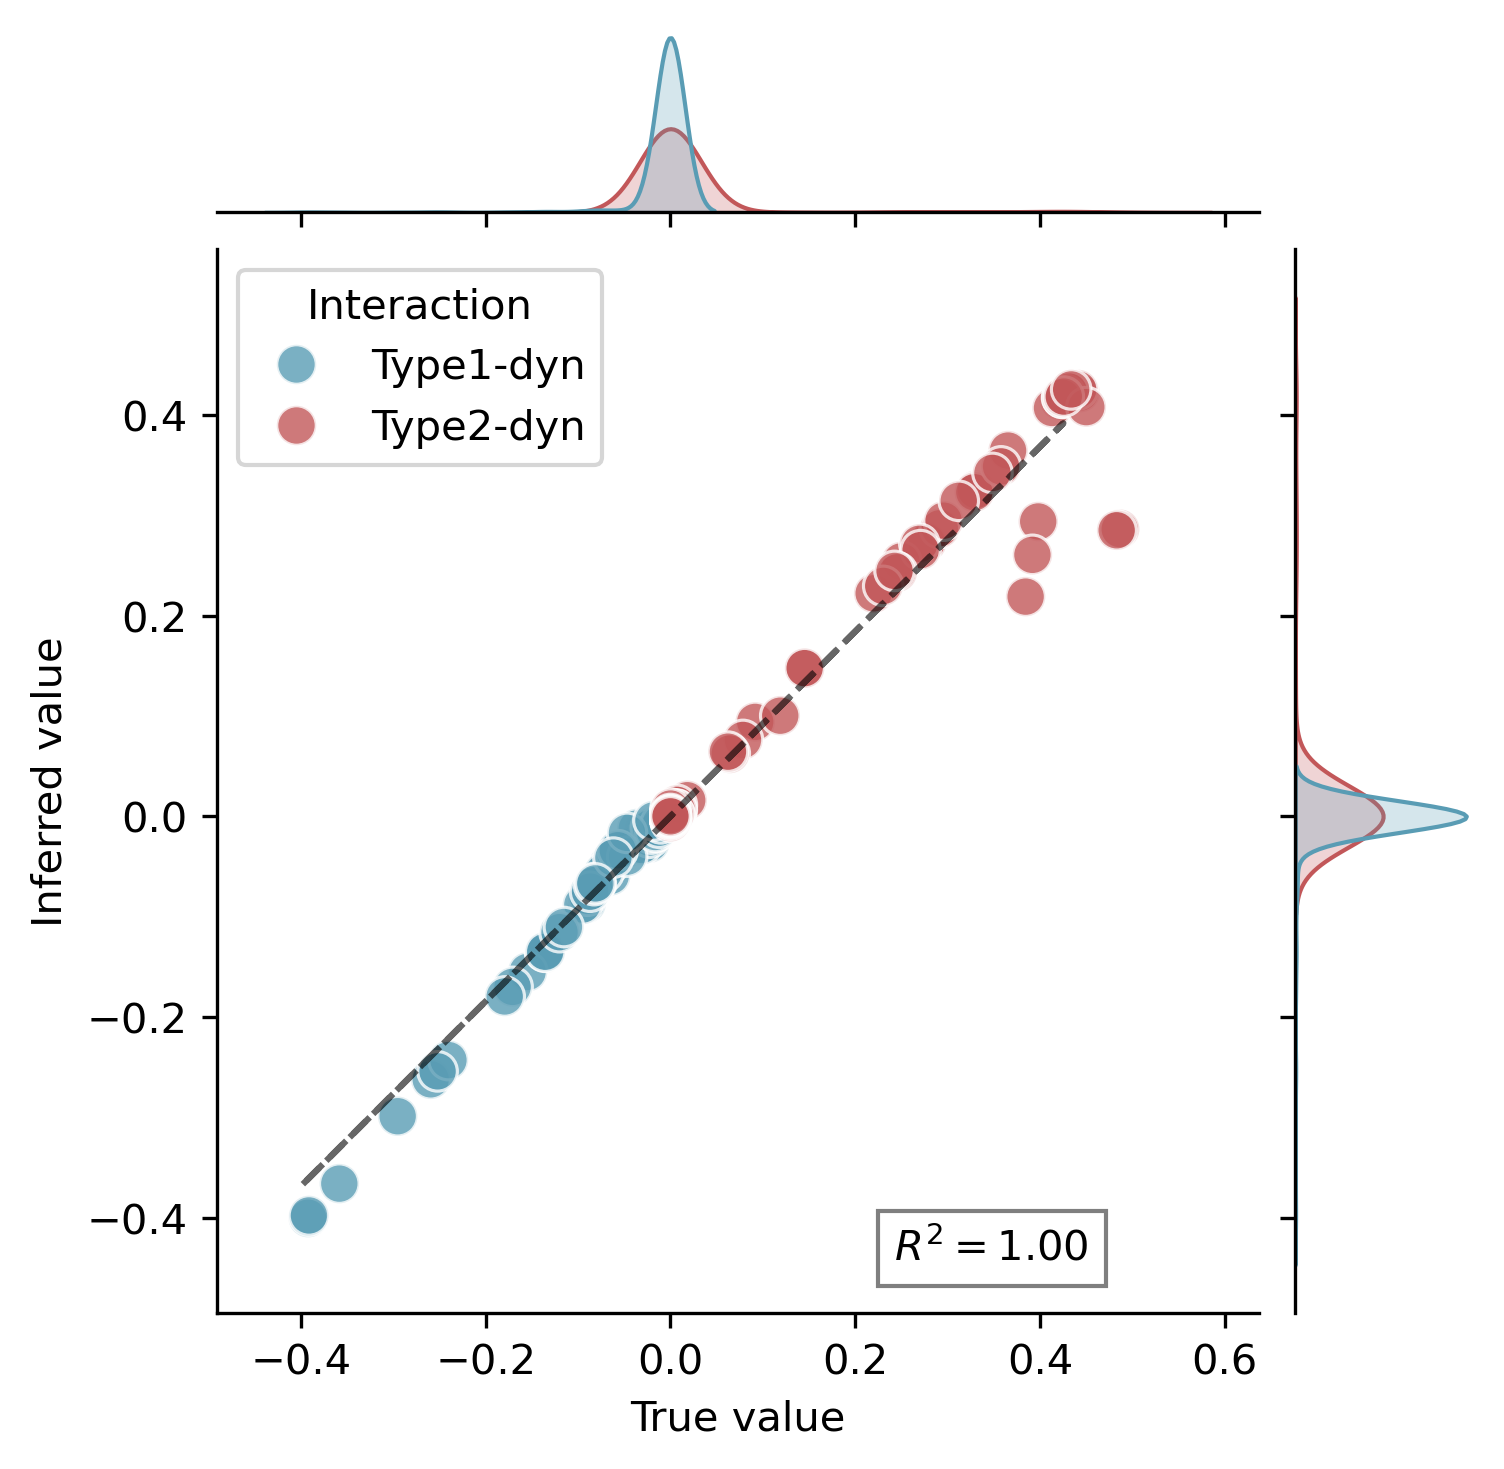

In [32]:
import seaborn as sns
import matplotlib as mpl
import scipy.optimize as sciopt
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.style.use('default') 
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
# figure = plt.figure(figsize=(10,10))

# palette = ['#8D91C0','#B8ACB9']
palette = ['#599CB4','#C25759']
g = sns.jointplot(data=interact, kind='scatter', 
                  x="True", y="Inferred",
                  hue='Interaction',
                  alpha=0.8, palette = palette,
                  joint_kws=dict(s=90),
                  marginal_kws=dict(bw_adjust=2),
                  height=5,             
)

# g.ax_joint.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

g.ax_joint.set(
    xlabel='True value', 
    ylabel='Inferred value',
    )

parameterx = np.polyfit(interact['True'].values,interact['Inferred'].values,1)
fx = np.poly1d(parameterx)
# g.ax_joint.plot(interact['True'].values,fx(interact['True'].values),c='#E4AAA5',linestyle='--',lw=1.5)
g.ax_joint.plot(interact['Inferred'].values,fx(interact['Inferred'].values),alpha = 0.6,c='k',linestyle='--',lw=1.5)
corrx = np.corrcoef(interact['Inferred'].values,fx(interact['Inferred'].values))[0,1]
print(corrx**2)
bbox = dict(fc='1',alpha=0.5,facecolor='white')
plt.text(0.65, 0.05, '$R^2=%.2f$' % (corrx**2), transform=g.ax_joint.transAxes, size=10, bbox=bbox)

# interact['Residual'] = (interact['True'] - interact['Inferred'])
# plt.savefig('figure2/v6/HR20nodes_2type_interaction_fitting_anothercolor.pdf')

### equation inference

In [33]:
from utils.Interaction_func import *
from utils.Self_func import *
msg_type2 = msgs[msgs['T'] < -0.5]
xi = msg_type2['x1'].values
xj = msg_type2['x2'].values
G_type22 = msg_type2.iloc[:,-2].values
# coup_value_type22 = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) # inhibitory
goal = G_type22.reshape(-1,1) # G(xi,xj)
goal = pd.DataFrame(data = goal, columns =['e0'])
EleMatrix = ElementaryFunctions_Matrix(xi,xj)
EleMatrix = EleMatrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [34]:
print(EleMatrix.columns)

Index(['xj', 'xixj', 'xjMinusxi', 'sinxj', 'sinxixj', 'sinxjMinusxi',
       'xisinxj', 'expxj', 'expxixj', 'expxjMinusxi', 'xiexpxj', 'fracxj',
       'fracxixj', 'fracxjMinusxi', 'xifracxj', 'sigmoidxj', 'sigmoidxixj',
       'sigmoidXjMinusXi', 'xisigmoidxj', 'sigmoidxj101', 'sigmoidxixj101',
       'sigmoidXjMinusXi101', 'xisigmoidxj101', 'tanhxj', 'tanhxixj',
       'tanhxjMinusxi', 'xitanhxj', 'hillxj', 'hillxixj', 'hillxjMinusxi',
       'xihillxj', 'hillxj2', 'hillxixj2', 'hillxjMinusxi2', 'hillxj5',
       'hillxixj5', 'hillxjMinusxi5'],
      dtype='object')


In [35]:
X = EleMatrix.copy()
y = goal.copy()

X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:] # pandas
out = np.array(y) # shape(n,1)
y1 = (out[:,0]) # shape(n,)

In [36]:
reg1 = LassoCV(cv=5, fit_intercept=False, precompute=True, n_jobs=-1, max_iter=5000).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.983867347240448
Best threshold: 0.030


In [37]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
xitanhxj               0.001327
hillxixj2              0.003008
sinxjMinusxi           0.004177
hillxjMinusxi2         0.006512
sigmoidXjMinusXi101    0.011222
expxjMinusxi          -0.014477
expxj                  0.014924
xiexpxj               -0.015937
xisigmoidxj101        -0.092872
sigmoidxj101           0.304388
dtype: float32


In [38]:
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LassoCV(cv=5, fit_intercept=intercept, n_jobs=-1, max_iter=1000).fit(X_lib,Y_goal)
    coef = pd.Series(reg.coef_, index=X_lib.columns)
    if intercept == True:
        coef['constant'] = reg.intercept_
        num_params = len(coef)
    else:
        num_params = len(coef)    
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    sort = coef.sort_values()
    print(coef)
    return Score, mse, aic

In [39]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = EleMatrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = EleMatrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X,columns=[imp_no_cons.index[-1]])
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101    0.359409
dtype: float32
0.9541705250740051 0.00015311697 -368938.95382270165 sigmoidxj101


sigmoidxj101      0.303338
xisigmoidxj101   -0.075425
dtype: float32
0.9691022634506226 0.00010322989 -385495.1889768581 xisigmoidxj101


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101      0.302850
xisigmoidxj101   -0.070926
xiexpxj          -0.000800
dtype: float32
0.9690728187561035 0.0001033282 -385453.2085982531 xiexpxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101      0.301170
xisigmoidxj101   -0.071303
xiexpxj          -0.000659
expxj             0.000338
dtype: float32
0.9690504670143127 0.00010340276 -385420.9143153343 expxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101      0.296257
xisigmoidxj101   -0.064069
xiexpxj          -0.027132
expxj             0.024004
expxjMinusxi     -0.017577
dtype: float32
0.9826220870018005 5.8059806e-05 -409659.5513819285 expxjMinusxi


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101           0.293950
xisigmoidxj101        -0.065946
xiexpxj               -0.026389
expxj                  0.023718
expxjMinusxi          -0.017704
sigmoidXjMinusXi101    0.005947
dtype: float32
0.9831311106681824 5.635914e-05 -410906.1786580351 sigmoidXjMinusXi101


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101           0.302005
xisigmoidxj101        -0.059837
xiexpxj               -0.028195
expxj                  0.022319
expxjMinusxi          -0.018122
sigmoidXjMinusXi101    0.004341
hillxjMinusxi2         0.003510
dtype: float32
0.9835389852523804 5.4996406e-05 -411932.19417216006 hillxjMinusxi2


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101           0.299746
xisigmoidxj101        -0.065793
xiexpxj               -0.027623
expxj                  0.023101
expxjMinusxi          -0.018513
sigmoidXjMinusXi101    0.000877
hillxjMinusxi2         0.005849
sinxjMinusxi           0.002712
dtype: float32
0.9841164946556091 5.3067106e-05 -413430.0384347654 sinxjMinusxi


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101           0.299000
xisigmoidxj101        -0.071383
xiexpxj               -0.026945
expxj                  0.023298
expxjMinusxi          -0.019066
sigmoidXjMinusXi101    0.003487
hillxjMinusxi2         0.005276
sinxjMinusxi           0.003361
hillxixj2              0.002302
dtype: float32
0.9848529100418091 5.060661e-05 -415421.9911308968 hillxixj2


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101           0.299342
xisigmoidxj101        -0.064531
xiexpxj               -0.028492
expxj                  0.023803
expxjMinusxi          -0.019309
sigmoidXjMinusXi101    0.002151
hillxjMinusxi2         0.003352
sinxjMinusxi           0.003155
hillxixj2              0.004594
xitanhxj              -0.002018
dtype: float32
0.9847168922424316 5.106104e-05 -415044.52808915084 xitanhxj


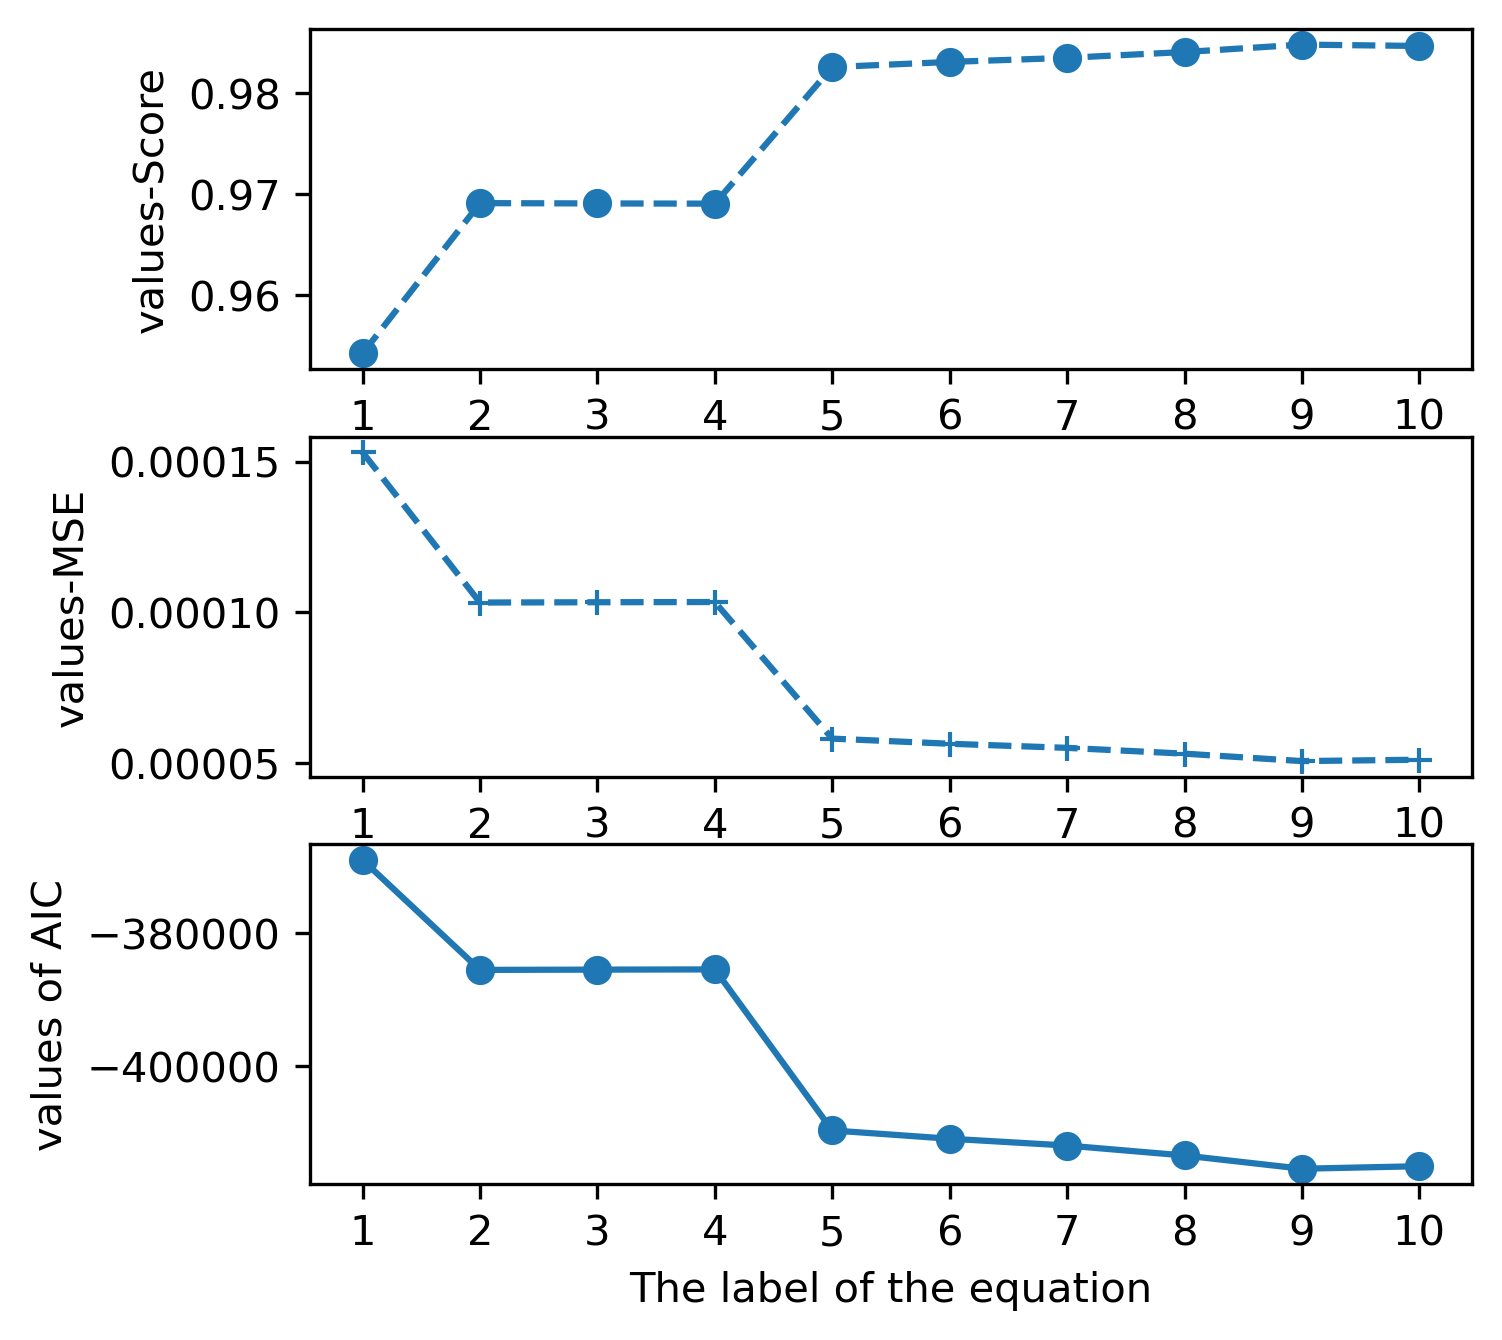

In [40]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
# plt.savefig('figure2/HR_inhibitory_equation.pdf')
plt.show()

In [41]:
X = EleMatrix.copy()
y = goal.copy()

Xfind_inh = pd.concat([X['sigmoidxj101'],X['xisigmoidxj101']],axis=1)
yfind_inh = y['e0']#dim
model_lineari = LinearRegression(fit_intercept=False)
model_lineari.fit(Xfind_inh,yfind_inh)
ai = model_lineari.coef_
ai

array([ 0.30345502, -0.07572953], dtype=float32)

In [42]:
# coup_value_type22 = 0.15*(2-x_i)/(1+np.exp(-10*(x_j-1))) # excitatory

In [43]:
t = [0.3,-0.15]
sm = 0
for i in range(len(ai)):
    s = np.abs(ai[i]-t[i])/(np.abs(ai[i])+np.abs(t[i]))
    sm += s
smape_Gi = sm/len(ai)
print(smape_Gi)
smape_Gi = np.mean(np.abs(ai - t) / (np.abs(ai + t)))
smape_Gi

0.16737477330939177


0.16737477330939177

In [44]:
msg_type1 = msgs[msgs['T'] > 0.5]
# msg_type1 = msgs[msgs['T'] >0.5]
xi = msg_type1['x1'].values
xj = msg_type1['x2'].values
G_type11 = msg_type1.iloc[:,-3].values
goal = G_type11.reshape(-1,1) # G(xi,xj)
goal = pd.DataFrame(data = goal, columns =['e0'])
EleMatrix = ElementaryFunctions_Matrix(xi,xj)
EleMatrix = EleMatrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [45]:
X = EleMatrix.copy()
y = goal.copy()

X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:] # pandas
out = np.array(y) # shape(n,1)
y1 = (out[:,0]) # shape(n,)

In [46]:
reg1 = LassoCV(cv=5, fit_intercept=False, precompute=True, n_jobs=-1, max_iter=5000).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9973611831665039
Best threshold: 0.027


In [47]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
xiexpxj           1.000000e-10
fracxj            1.000000e-10
fracxixj          1.000000e-10
fracxjMinusxi     1.000000e-10
xifracxj          1.000000e-10
expxjMinusxi      1.000000e-10
hillxjMinusxi5    1.000000e-10
hillxixj          4.054565e-07
xisigmoidxj101   -1.620135e-01
sigmoidxj101     -2.237978e-01
dtype: float32


In [48]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = EleMatrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = EleMatrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X,columns=[imp_no_cons.index[-1]])
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])
    # if Score>0.9:
    #     break

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101   -0.088773
dtype: float32
0.497081458568573 0.00022232255 -487858.1167020913 sigmoidxj101
sigmoidxj101     -0.223751
xisigmoidxj101   -0.161969
dtype: float32
0.9973597526550293 1.1671564e-06 -792330.5327996972 xisigmoidxj101


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -2.230347e-01
xisigmoidxj101   -1.612447e-01
hillxixj          6.088669e-07
dtype: float32
0.9973318576812744 1.1794951e-06 -791718.5952289379 hillxixj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -2.230347e-01
xisigmoidxj101   -1.612447e-01
hillxixj          6.088605e-07
hillxjMinusxi5    2.901689e-10
dtype: float32
0.9973318576812744 1.1794955e-06 -791716.5784577737 hillxjMinusxi5


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -2.200897e-01
xisigmoidxj101   -1.576917e-01
hillxixj          5.670737e-07
hillxjMinusxi5    0.000000e+00
expxjMinusxi      4.276845e-05
dtype: float32
0.9969490170478821 1.3487339e-06 -783937.9661806595 expxjMinusxi


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -2.200898e-01
xisigmoidxj101   -1.576916e-01
hillxixj          5.671045e-07
hillxjMinusxi5    0.000000e+00
expxjMinusxi      4.278667e-05
xifracxj         -2.653026e-08
dtype: float32
0.9969490170478821 1.3487359e-06 -783935.8830692762 xifracxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -2.200898e-01
xisigmoidxj101   -1.576916e-01
hillxixj          5.671010e-07
hillxjMinusxi5    0.000000e+00
expxjMinusxi      4.278611e-05
xifracxj         -2.652358e-08
fracxjMinusxi    -5.715569e-11
dtype: float32
0.9969490170478821 1.3487363e-06 -783933.8635136739 fracxjMinusxi


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -2.200898e-01
xisigmoidxj101   -1.576915e-01
hillxixj          5.670827e-07
hillxjMinusxi5    0.000000e+00
expxjMinusxi      4.278978e-05
xifracxj         -7.825334e-08
fracxjMinusxi    -5.716887e-11
fracxixj          6.399714e-08
dtype: float32
0.9969490170478821 1.3487331e-06 -783932.0004030286 fracxixj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -2.200897e-01
xisigmoidxj101   -1.576915e-01
hillxixj          5.670725e-07
hillxjMinusxi5    0.000000e+00
expxjMinusxi      4.278353e-05
xifracxj         -9.147290e-08
fracxjMinusxi    -5.717334e-11
fracxixj          6.199392e-08
fracxj           -2.749877e-08
dtype: float32
0.9969490170478821 1.3487302e-06 -783930.1275148614 fracxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101     -2.176193e-01
xisigmoidxj101   -1.546498e-01
hillxixj          5.701141e-07
hillxjMinusxi5   -3.868376e-09
expxjMinusxi     -3.794419e-04
xifracxj         -9.566637e-07
fracxjMinusxi    -1.152209e-10
fracxixj         -1.818400e-08
fracxj           -8.254299e-07
xiexpxj          -1.312974e-03
dtype: float32
0.9967198371887207 1.4500406e-06 -779727.3021278513 xiexpxj


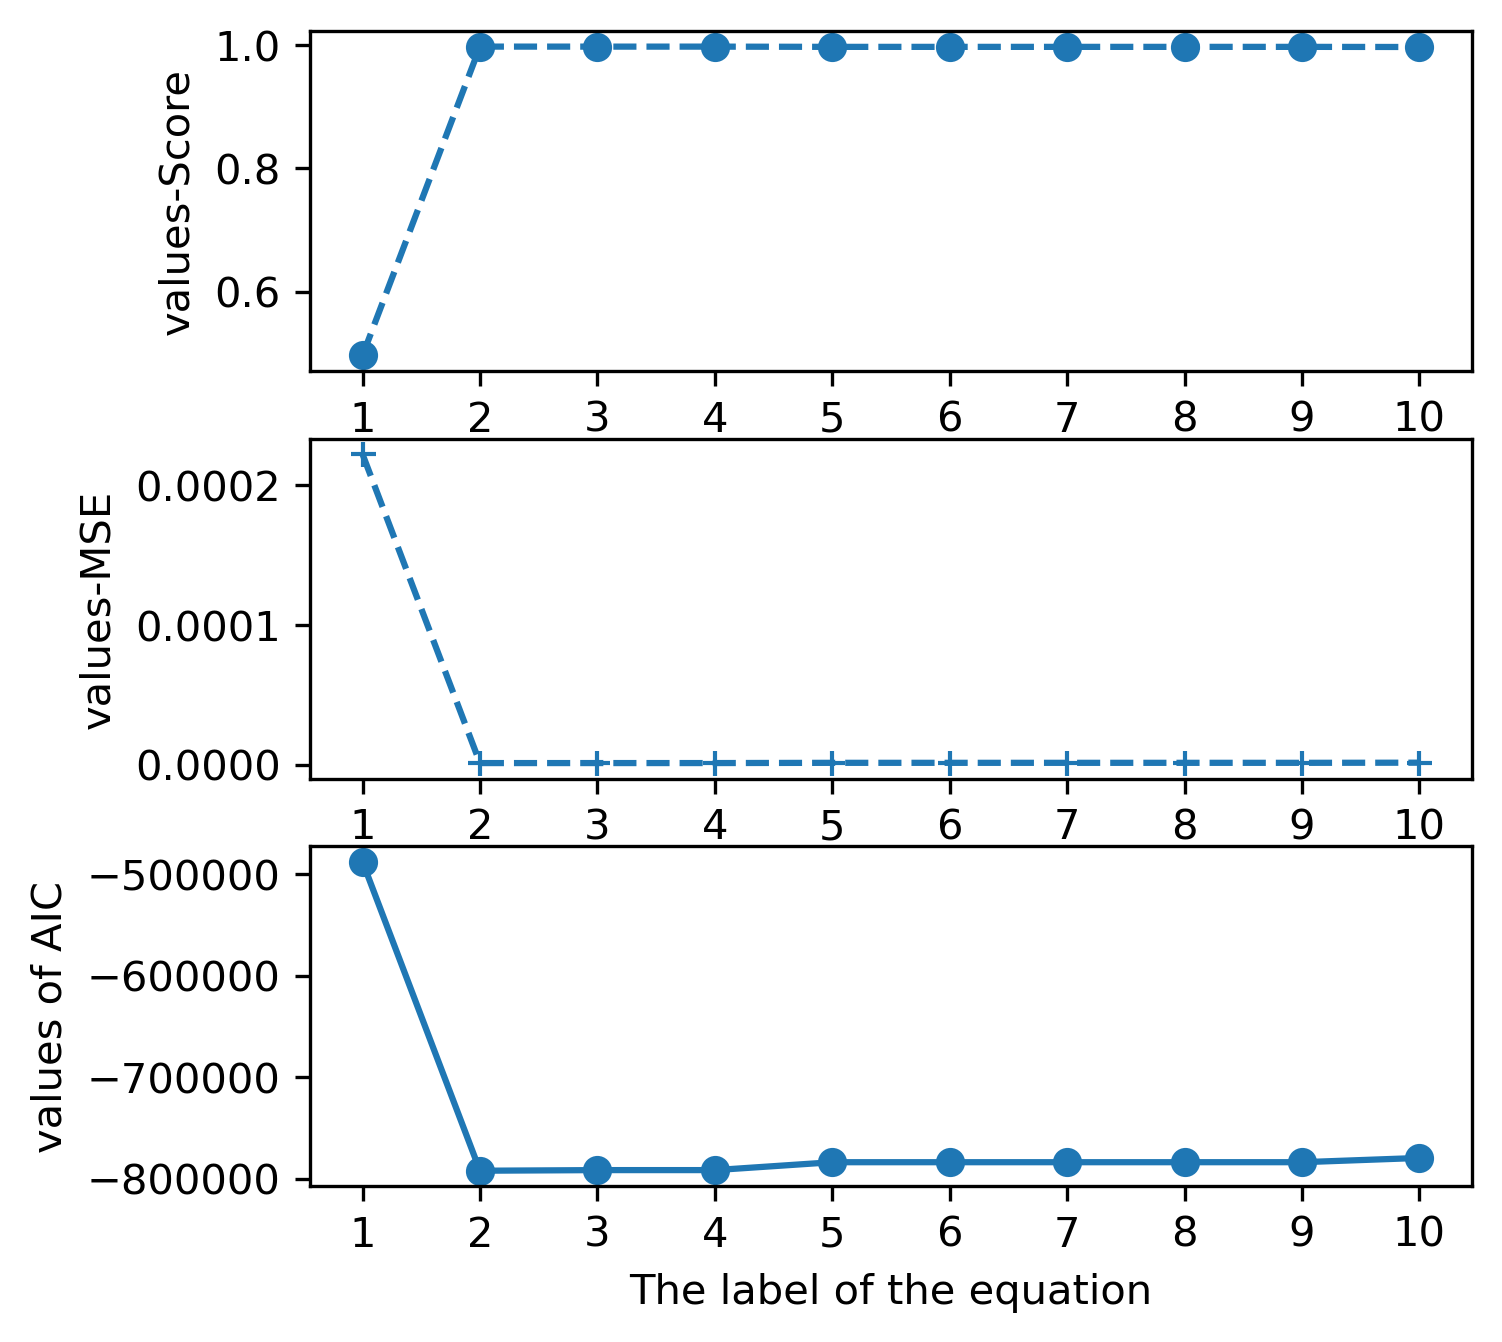

In [49]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
# plt.savefig('figure2/HR_excitory_equation.pdf')
plt.show()

In [50]:
X = EleMatrix.copy()
y = goal.copy()

Xfind_exi = pd.concat([X['sigmoidxj101'],X['xisigmoidxj101']],axis=1)
yfind_exi = y['e0']#dim
model_lineare = LinearRegression(fit_intercept=False)
model_lineare.fit(Xfind_exi,yfind_exi)
ae = model_lineare.coef_
ae

array([-0.22433913, -0.16255732], dtype=float32)

In [ ]:
# coup_value_type11 = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) # inhibitory

In [51]:
t = [-0.225,-0.15]
sm = 0
for i in range(len(ae)):
    s = np.abs(ae[i]-t[i])/(np.abs(ae[i])+np.abs(t[i]))
    sm += s
smape_Ge = sm/len(ae)
print(smape_Ge)

0.02082340826111193


so, type2 is excitatory, and type1 is inhibitory

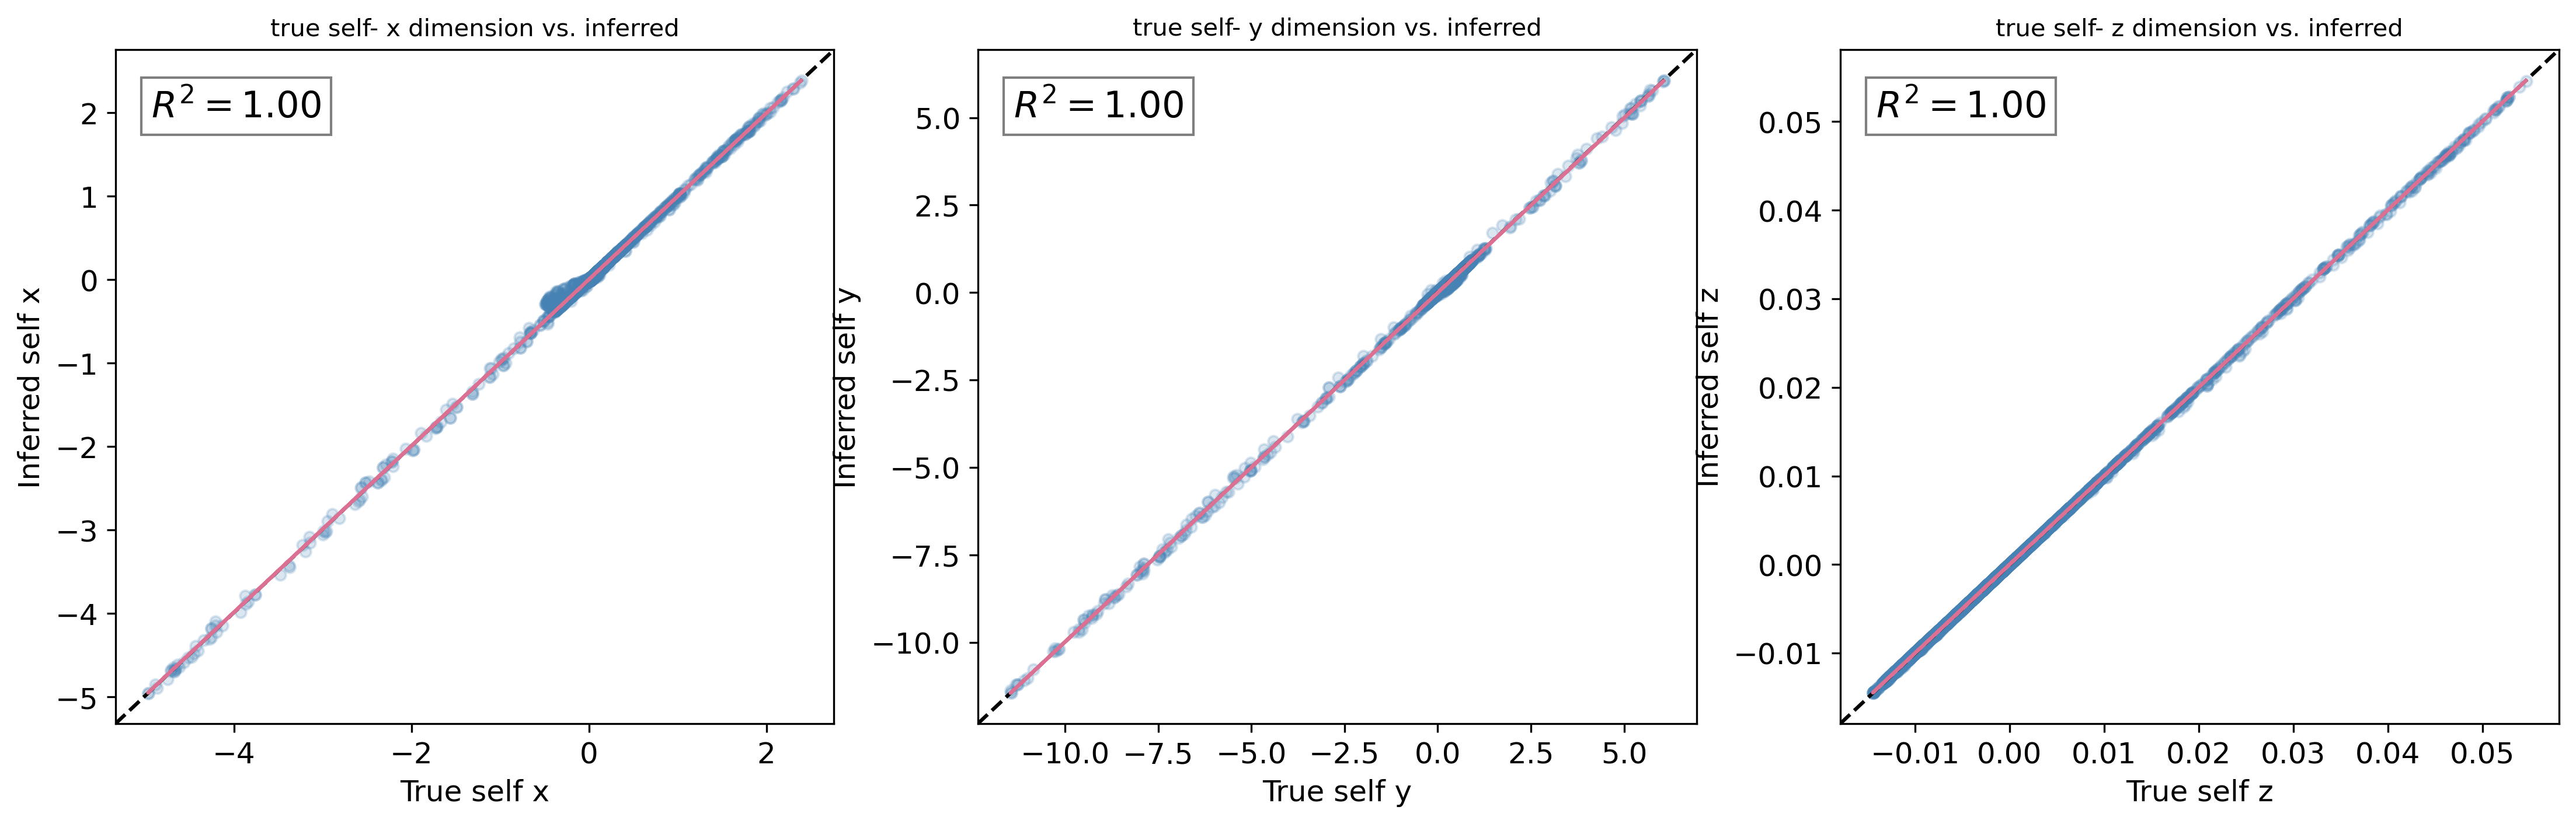

In [52]:
import random
import matplotlib.pyplot as plt
best_selfDyn = selfdyn
sx = best_selfDyn['s1'].values
sx_true = best_selfDyn['y']-best_selfDyn['x']**3+3*best_selfDyn['x']**2-best_selfDyn['z']+3.24
sy = best_selfDyn['s2'].values
sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = 0.005*(4*(best_selfDyn['x']+1.6)-best_selfDyn['z'])

R = random.sample(range(0,len(selfdyn['s2'])),4000) 
sx = sx[R]
sx_true = sx_true[R]
sy = sy[R]
sy_true = sy_true[R]
sz = sz[R]
sz_true = sz_true[R]

plt.rcParams.update({'font.size': 12}) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=20,c ='steelblue', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1.5)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")

ax2 = fig.add_subplot(1,3,2)
plt.title("true self- y dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='palevioletred',lw=1.5)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True self y")
plt.ylabel("Inferred self y")


ax3 = fig.add_subplot(1,3,3)
plt.title("true self- z dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=20,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='palevioletred',lw=1.5)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True self z")
plt.ylabel("Inferred self z")
# plt.savefig('figure2/HR20nodes_selfDynamics_fitting.pdf')
plt.show()
plt.close()

In [53]:
import pandas as pd
sx_true = np.array(sx_true)
sx = np.array(sx)
xdim = pd.concat([pd.DataFrame(sx_true),pd.DataFrame(sx)],axis=1)
sy_true = np.array(sy_true)
sy = np.array(sy)
ydim = pd.concat([pd.DataFrame(sy_true),pd.DataFrame(sy)],axis=1)
sz_true = np.array(sz_true)
sz = np.array(sz)
zdim = pd.concat([pd.DataFrame(sz_true),pd.DataFrame(sz)],axis=1)
selfF = pd.concat([xdim,ydim,zdim],axis=0)
selfF.columns = ['True','Inferred']
selfF['Dimension'] = ['x-dim']*len(R)+['y-dim']*len(R)+['z-dim']*len(R)

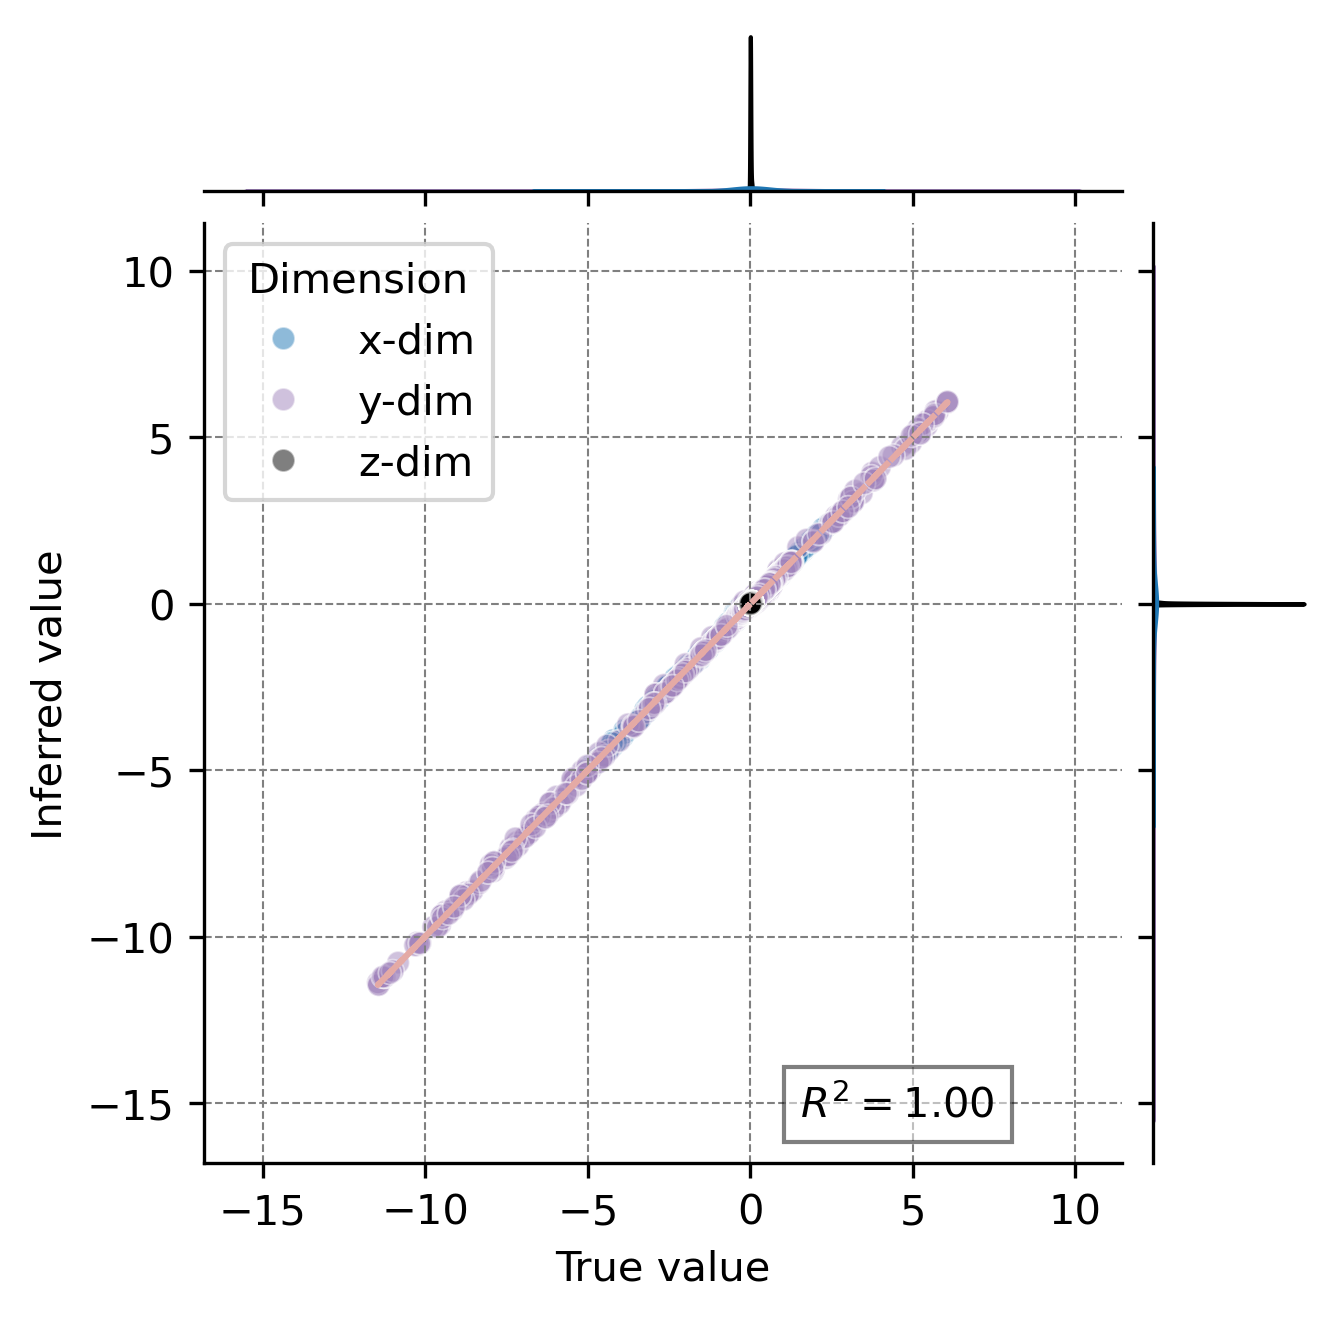

In [ ]:
import seaborn as sns
import matplotlib as mpl
import scipy.optimize as sciopt
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.style.use('default') 
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
g = sns.jointplot(data=selfF, kind='scatter', 
                  x="True", y="Inferred",
                  hue='Dimension',
                  alpha=0.5, palette = ['C20','#A184BC','k'],
                  joint_kws=dict(s=30),
                  marginal_kws=dict(bw_adjust=5),
                  height=4.5,             
)

g.ax_joint.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

g.ax_joint.set(
    xlabel='True value', 
    ylabel='Inferred value',
    )

parameterx = np.polyfit(selfF['True'].values,selfF['Inferred'].values,1)
fx = np.poly1d(parameterx)
g.ax_joint.plot(selfF['True'].values,fx(selfF['True'].values),c='#E4AAA5',linestyle='--',lw=1.5)
corrx = np.corrcoef(selfF['True'].values,fx(selfF['True'].values))[0,1]
bbox = dict(fc='1',alpha=0.5,facecolor='white')
plt.text(0.65, 0.05, '$R^2=%.2f$' % (corrx**2), transform=g.ax_joint.transAxes, size=10, bbox=bbox)

# plt.savefig('figure2/HR20nodes_selfDynamics_fitting_joinplot.pdf')


5.009953498840332 11.314499855041504 0.05271070823073387
(3000,)
(3000, 2)


/tmp/ipykernel_85287/1930887009.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(desamerror4self, x="HR-Dyn", y="Predict error", size=5, jitter=True, order = order, palette=palette,alpha=0.5)
/tmp/ipykernel_85287/1930887009.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HR-Dyn', y='Predict error', data=error4self,whis=[0, 100],width=.4, order = order, palette=palette,showfliers=False)


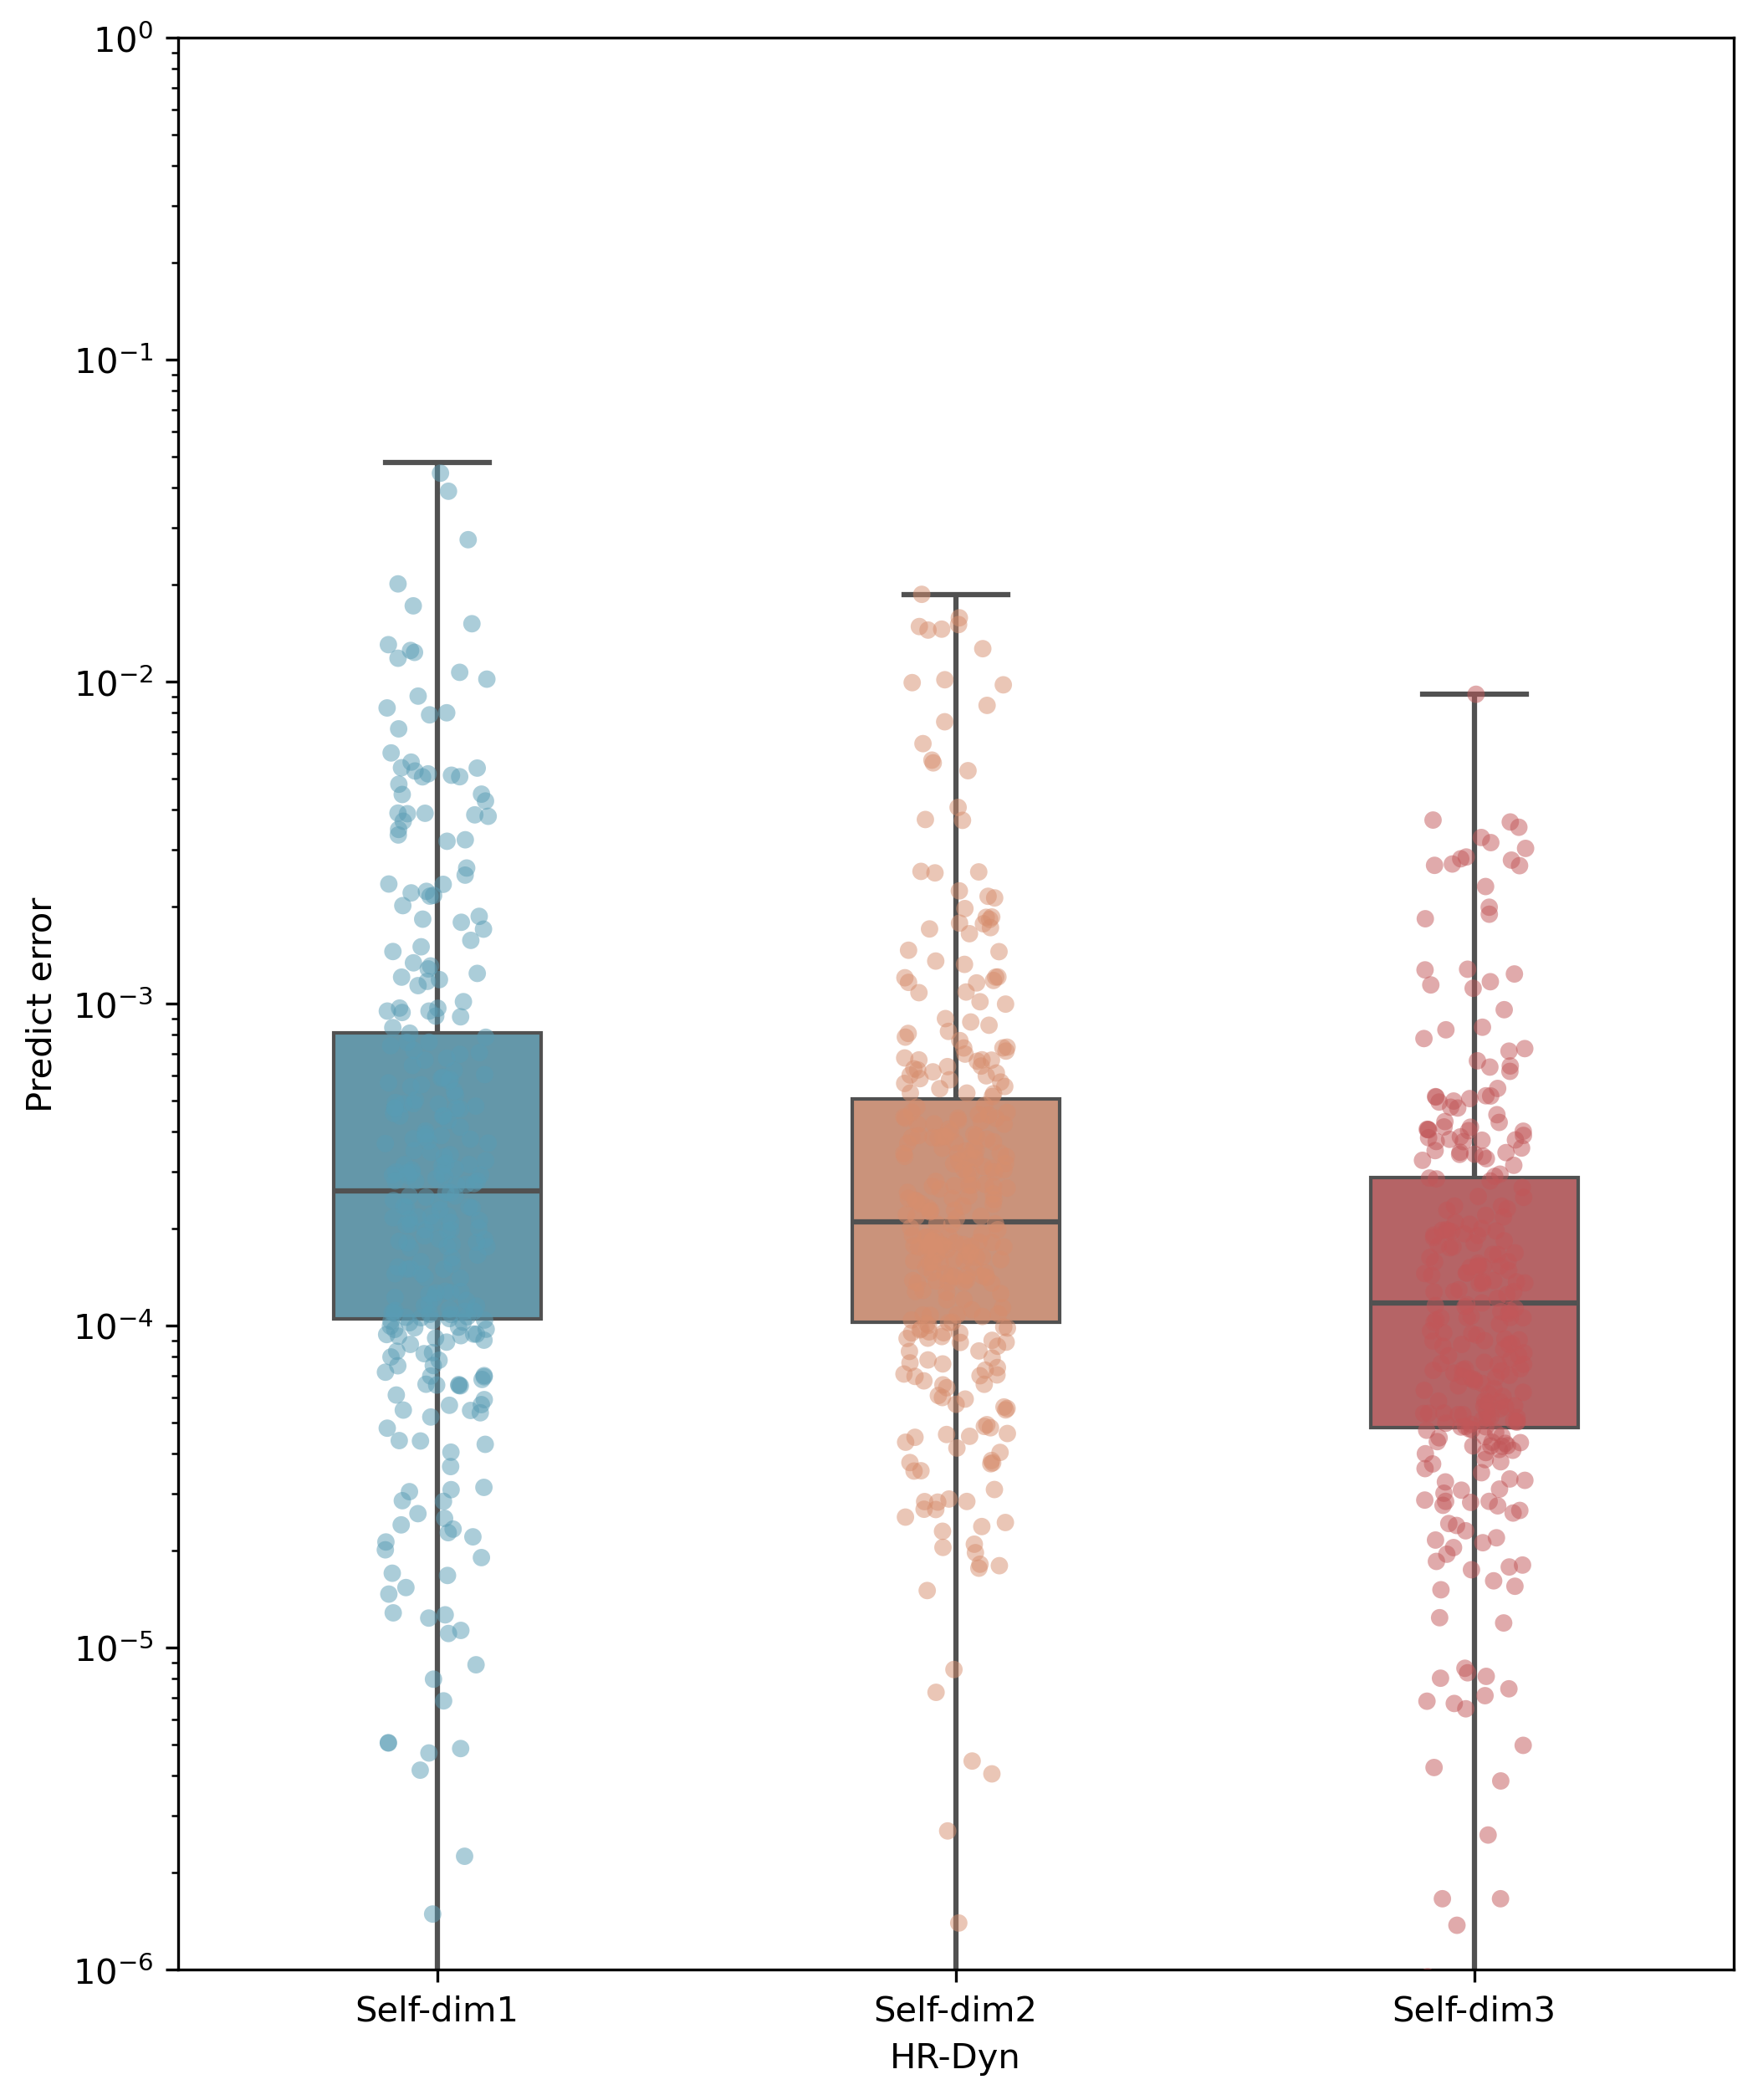

In [55]:
np.random.seed(2035)

sx = best_selfDyn['s1'].values
sx_true = best_selfDyn['y']-best_selfDyn['x']**3+3*best_selfDyn['x']**2-best_selfDyn['z']+3.24
sy = best_selfDyn['s2'].values
sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = 0.005*(4*(best_selfDyn['x']+1.6)-best_selfDyn['z'])

index = np.random.randint(0, len(sx_true), 1000)

sx_true = sx_true[index]
sx = sx[index]
sy_true = sy_true[index]
sy = sy[index]
sz_true = sz_true[index]
sz = sz[index]

mx = max(np.abs(sx_true))
my = max(np.abs(sy_true))
mz = max(np.abs(sz_true))
print(mx,my,mz)

norm_errorx = np.abs((sx - sx_true)/mx)
norm_errory = np.abs((sy - sy_true)/my)
norm_errorz = np.abs((sz - sz_true)/mz)

error4self = pd.DataFrame()
errorselfall = np.hstack((norm_errorx,norm_errory,norm_errorz))
print(errorselfall.shape)
error4self['Predict error'] = errorselfall
error4self['HR-Dyn'] = ['Self-dim1']*int(len(index))+['Self-dim2']*int(len(index))+['Self-dim3']*int(len(index))
print(error4self.shape)

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
f, ax = plt.subplots(figsize=(8, 10))
order = ['Self-dim1', 'Self-dim2', 'Self-dim3']
palette = ['#599CB4','#D78E6E','#C25759']
desamerror4self = error4self.sample(frac=0.3)
sns.stripplot(desamerror4self, x="HR-Dyn", y="Predict error", size=5, jitter=True, order = order, palette=palette,alpha=0.5)
sns.boxplot(x='HR-Dyn', y='Predict error', data=error4self,whis=[0, 100],width=.4, order = order, palette=palette,showfliers=False)
ax.set_ylim(1e-6, 1)
ax.set_yscale('log')
for line in ax.lines:  
    line.set_linewidth(1.5)  
# plt.savefig('figure2/v5/HR_self_prediction_error_boxplot.pdf')
plt.show()

## infer equation

In [56]:
best_selfDyn = selfdyn

In [57]:
import sys
sys.path.append('utils/')
from utils.Self_func import *
Dimension = 3
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 3, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = False, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
print(self_matrix.columns)

Index(['x1', 'x2', 'x3', 'x1x1', 'x1x2', 'x1x3', 'x2x2', 'x2x3', 'x3x3',
       'x1x1x1', 'x1x1x2', 'x1x1x3', 'x1x2x2', 'x1x2x3', 'x1x3x3', 'x2x2x2',
       'x2x2x3', 'x2x3x3', 'x3x3x3'],
      dtype='object')


2nd self dimension

In [67]:
goal = best_selfDyn['s2'].values
goal = pd.DataFrame(data = goal, columns =['s2'])
X = self_matrix.copy()
y = goal.copy()

In [68]:
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [69]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=5000).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9997943939958327
Best threshold: 0.001


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.429e+02, tolerance: 2.980e+02
  model = cd_fast.enet_coordinate_descent(


In [70]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)

In [71]:
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 with constant.
x1x1x2      1.000000e-10
x1x2x2      1.000000e-10
x2x2        2.265868e-03
x1x2x3     -1.252095e-02
x1         -2.213318e-02
x2x3       -5.944056e-02
x1x1x1     -9.670782e-02
x1x1x3     -2.112746e-01
x2         -7.863541e-01
x1x1       -4.200993e+00
constant    9.788457e-01
dtype: float64


In [72]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_cons.shape[0]+1):
    if imp_cons.index[-i] != 'constant':
        tmp = self_matrix.copy()[imp_cons.index[-i]]
        if i == 1:
            X = self_matrix.copy()[imp_cons.index[-1]].values.reshape(-1,1)
            X = pd.DataFrame(X,columns=[imp_cons.index[-1]])
        else:
            X = pd.concat([X,tmp],axis=1)
    else:
        Cons = np.ones((y1.shape[0],1))*imp_cons['constant']
        X = pd.DataFrame(Cons)
        X.columns = ['constant']
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_cons.index[-i])
    # if Score>0.9:
    #     break

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant   -0.021077
dtype: float64
-2.0802959355137318e-10 2.0501744854915573 272813.4636728291 constant


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant    1.182318
x1x1       -1.176639
dtype: float64
0.23062456212532312 1.5773538921664207 173188.50268675684 x1x1


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant    1.013443
x1x1       -4.988587
x2         -0.998746
dtype: float64
0.9995607877257315 0.0009004617982325184 -2664783.0704935184 x2


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.82961325200085, tolerance: 61.27041031135491
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221.04776497062994, tolerance: 61.27041031135491
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/li

constant    1.018846
x1x1       -4.302016
x2         -0.990152
x1x1x3     -0.207800
dtype: float64
0.9988086044104316 0.002442568839352217 -2285579.8963794545 x1x1x3


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.6462878097991, tolerance: 63.69507189003212
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226.2676298017177, tolerance: 63.69507189003212
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.6900758151587, tolerance: 63.69507189003212
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaco

constant    1.019542
x1x1       -4.257488
x2         -0.991644
x1x1x3     -0.223140
x1x1x1      0.002766
dtype: float64
0.998713569803072 0.002637406366558938 -2256414.527023525 x1x1x1


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.38956358520409, tolerance: 62.03578592468256
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.01244710946276, tolerance: 62.03578592468256
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.35868815324056, tolerance: 62.03578592468256
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/ana

constant    1.010187
x1x1       -2.745968
x2         -0.448333
x1x1x3     -0.703112
x1x1x1      0.001371
x2x3       -0.173271
dtype: float64
0.9989882953560545 0.0020741710474389296 -2347701.606125058 x2x3


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.38956358520409, tolerance: 62.03578592468256
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.01244710946276, tolerance: 62.03578592468256
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.35868815324056, tolerance: 62.03578592468256
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/ana

constant    1.010166
x1x1       -2.746745
x2         -0.448122
x1x1x3     -0.702877
x1x1x1      0.001369
x2x3       -0.173342
x1          0.000000
dtype: float64
0.9989883476550253 0.002074063825423359 -2347719.25031936 x1


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.852e+03, tolerance: 7.792e+01
  model = cd_fast.enet_coordinate_descent(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant    0.952864
x1x1       -2.178933
x2         -0.305903
x1x1x3     -0.812572
x1x1x1     -0.171518
x2x3       -0.210151
x1          0.000000
x1x2x3     -0.016866
dtype: float64
0.9989795440999789 0.0020921126493573896 -2344424.736886727 x1x2x3


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.95535090122212, tolerance: 62.0847403775308
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.26808802107871, tolerance: 62.605340731128834
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.61925445776433, tolerance: 62.0847403775308
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anacon

constant    0.972485
x1x1       -2.263176
x2         -0.296227
x1x1x3     -0.775469
x1x1x1     -0.209844
x2x3       -0.206794
x1         -0.000000
x1x2x3     -0.021783
x2x2        0.002574
dtype: float64
0.9991369294390365 0.001769445242898038 -2408075.8973736516 x2x2


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.87406904958607, tolerance: 62.0847403775308
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.20908569234598, tolerance: 62.0847403775308
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.48079207358205, tolerance: 62.0847403775308
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anacond

constant    0.964587
x1x1       -2.219137
x2         -0.285501
x1x1x3     -0.783520
x1x1x1     -0.230147
x2x3       -0.213264
x1         -0.000000
x1x2x3     -0.026602
x2x2        0.000254
x1x2x2     -0.001822
dtype: float64
0.999112421611685 0.0018196905652185181 -2397433.7483544294 x1x2x2


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.27291600035187, tolerance: 62.03578592468256
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.89950202959608, tolerance: 62.03578592468256
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.99221256808323, tolerance: 62.03578592468256
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anac

constant    0.904660
x1x1       -2.171302
x2         -0.237211
x1x1x3     -0.721035
x1x1x1     -0.219760
x2x3       -0.205250
x1         -0.124672
x1x2x3     -0.029781
x2x2        0.019937
x1x2x2      0.000465
x1x1x2      0.061868
dtype: float64
0.9989828114548156 0.002085414001837512 -2345637.394935733 x1x1x2


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.231e+03, tolerance: 7.792e+01
  model = cd_fast.enet_coordinate_descent(


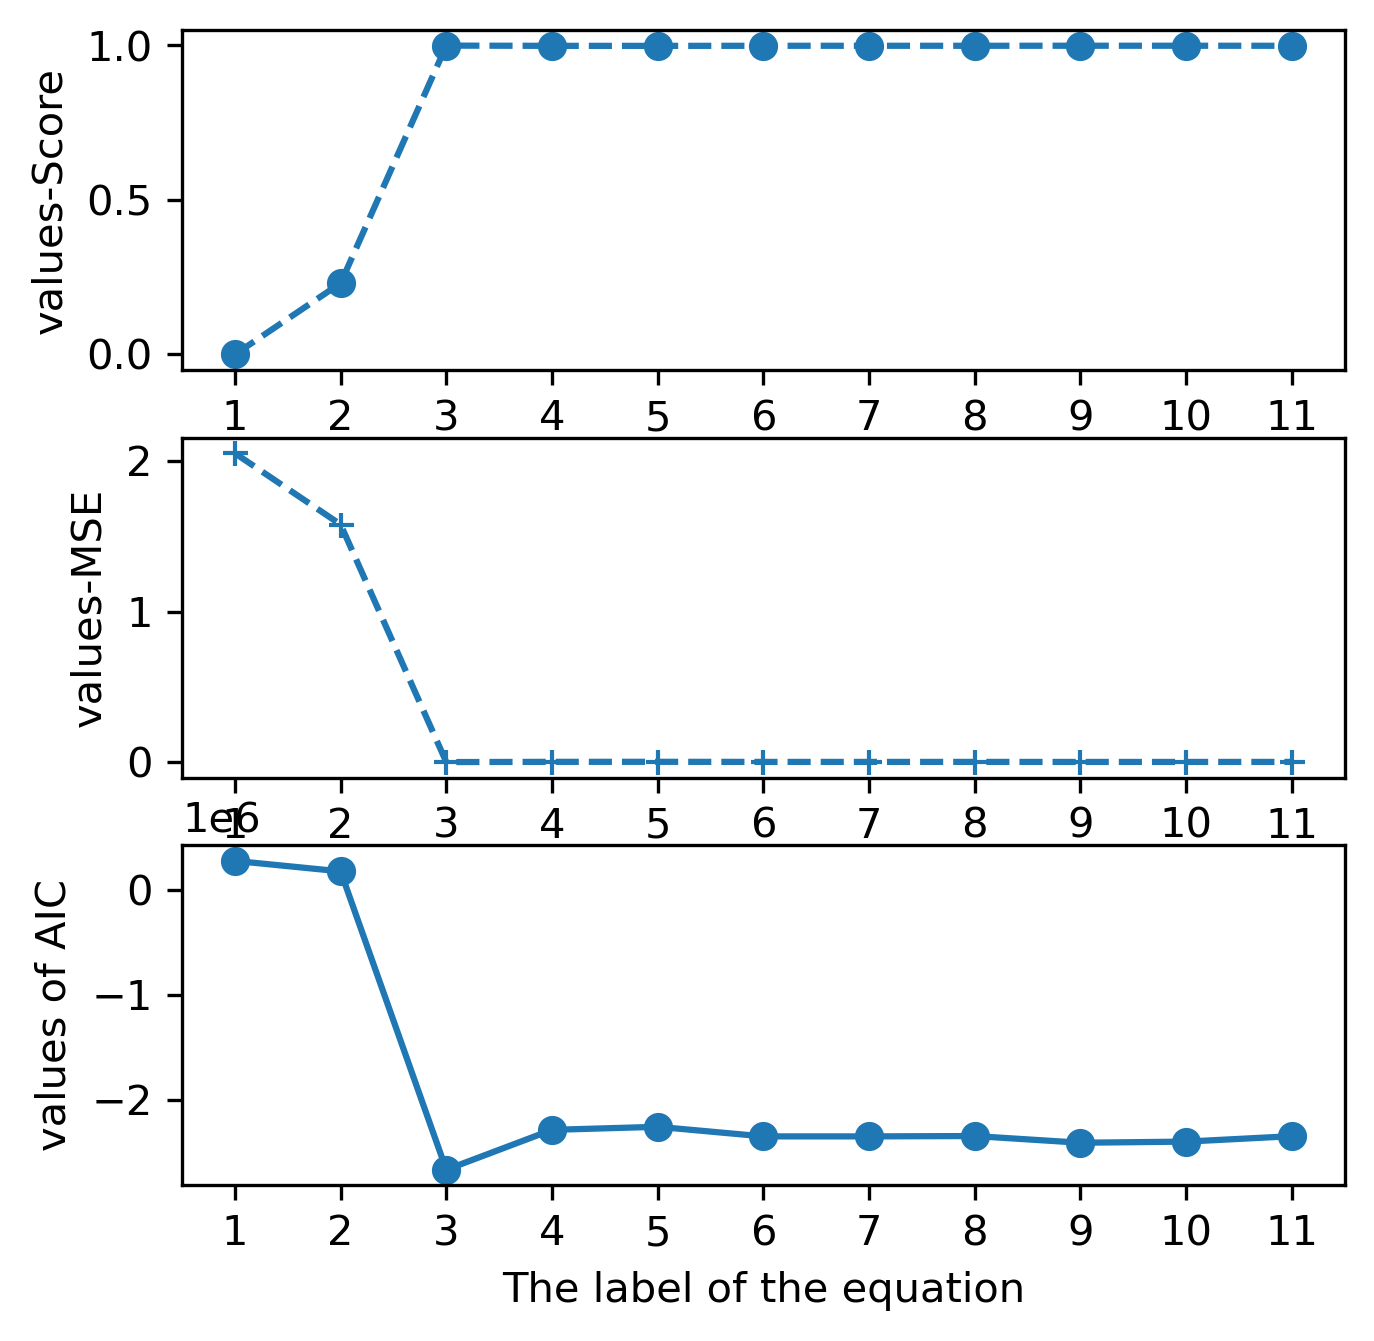

In [73]:
# Visualization
Index = np.arange(1,imp_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
# plt.savefig('figure2/HR_selfdim2_equation_only_polynomial.pdf')
plt.show()

In [75]:
X = self_matrix.copy()
y = goal.copy()
Xfind = pd.concat([X['x2'],X['x1x1']],axis=1)#pd.concat([v1,v2],axis=1)
yfind = y['s2']

model_linear = LinearRegression(fit_intercept=True)
model_linear.fit(Xfind,yfind)
b = model_linear.coef_
b1 = b.tolist()
print('constant:',model_linear.intercept_)
b1.append(model_linear.intercept_)
b1 = np.array(b1)
print(b1)

constant: 0.9952219165560174
[-1.00031101 -4.99756601  0.99522192]


In [159]:
# sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']

In [76]:
smape_dim2 = np.sum((np.abs(b1 - [-1,-5,1])) / (np.abs(b1 + [-1,-5,1])))/len(b1)
smape_dim2

0.000931233826890566

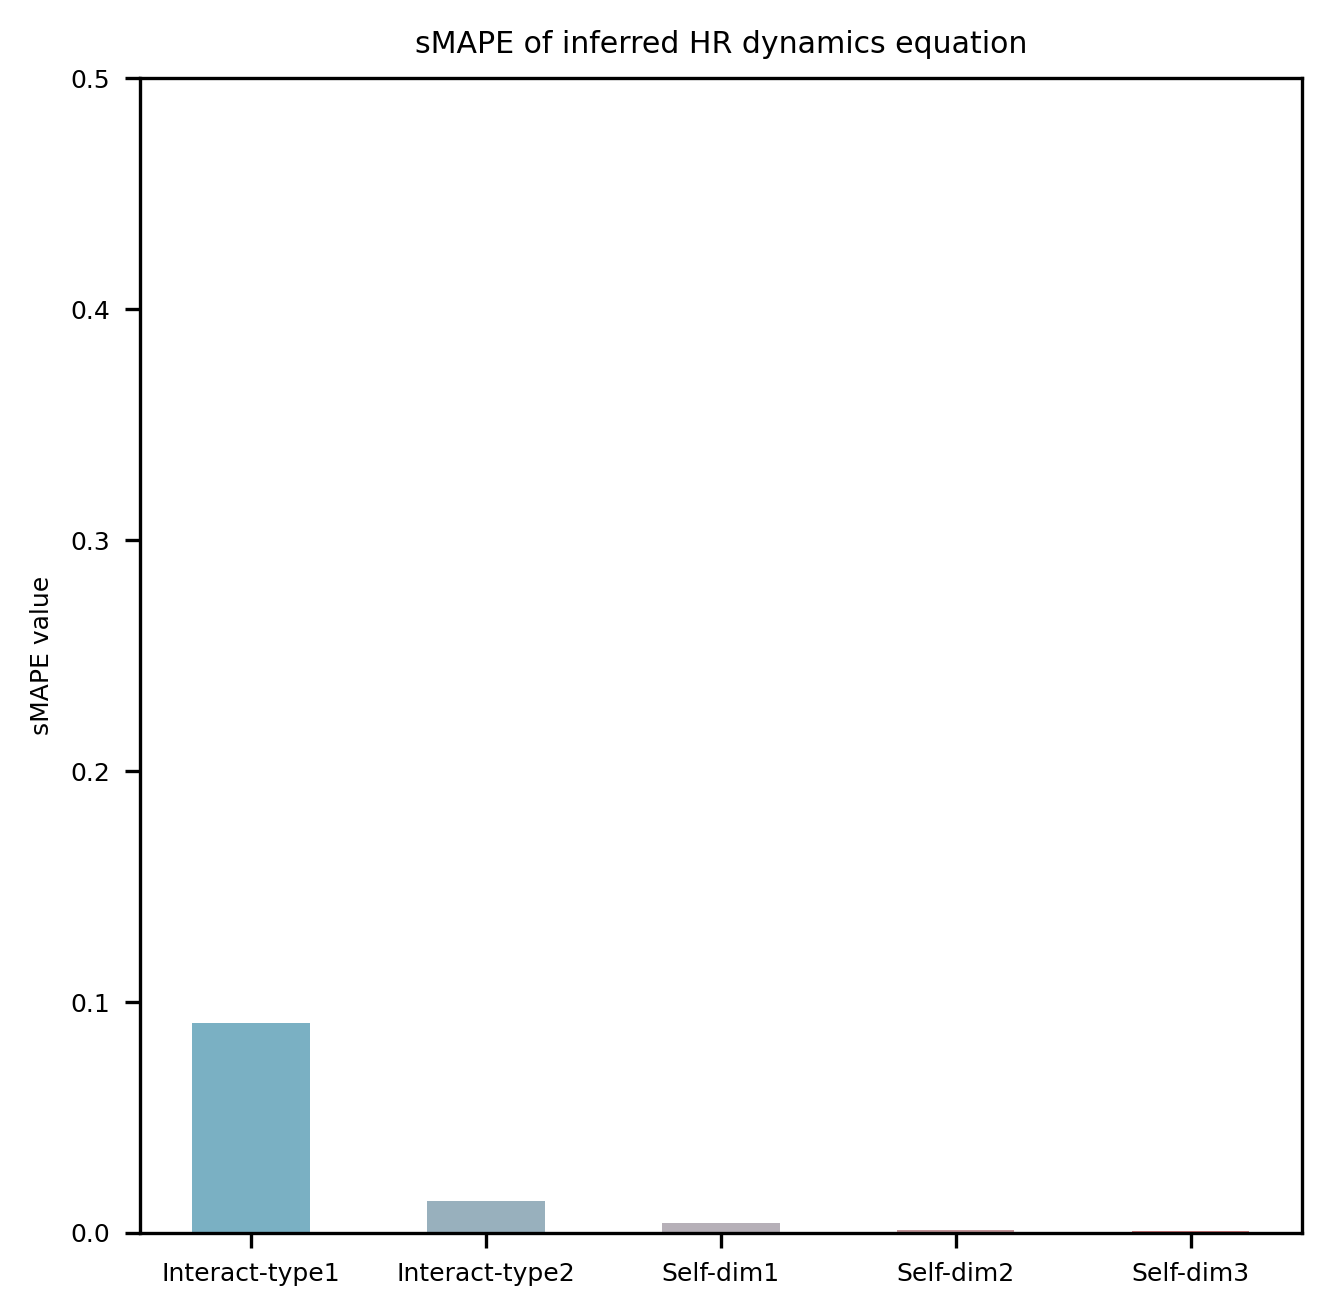

In [87]:
import matplotlib.pyplot as plt
import numpy as np  
from matplotlib.colors import LinearSegmentedColormap   

plt.rcParams.update({'font.size': 6})
values = np.load('inference_results_smape.npy')
labels = ['Interact-type1','Interact-type2', 'Self-dim1', 'Self-dim2', 'Self-dim3']

start_color = '#599CB4'  
end_color = '#C25759'    
mid_color = '#A49DA6'   
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [start_color, mid_color, end_color])
colors = custom_cmap(np.linspace(0, 1, len(labels)))
fig = plt.figure(figsize=(5,5))
plt.bar(labels, values, color=colors,width=0.5,alpha = 0.8)
plt.ylim(0,0.5)

plt.title('sMAPE of inferred HR dynamics equation')
plt.ylabel('sMAPE value')
# plt.savefig('figure2/v6/sMAPE_HR_equationinfer2_nolog.pdf')

plt.show()


## direct results from training process

In [88]:
path = data_path+'timeseries.pickle'
with open(path, 'rb') as f:
    objectAij, series= pickle.load(f)
with open(save_path+'weights_tau0.999.pkl', 'rb') as f:
    weights_over_epcs = pickle.load(f)

epc = 1999
weights_ind = weights_over_epcs[epc]
weights_ind = torch.Tensor(weights_ind)

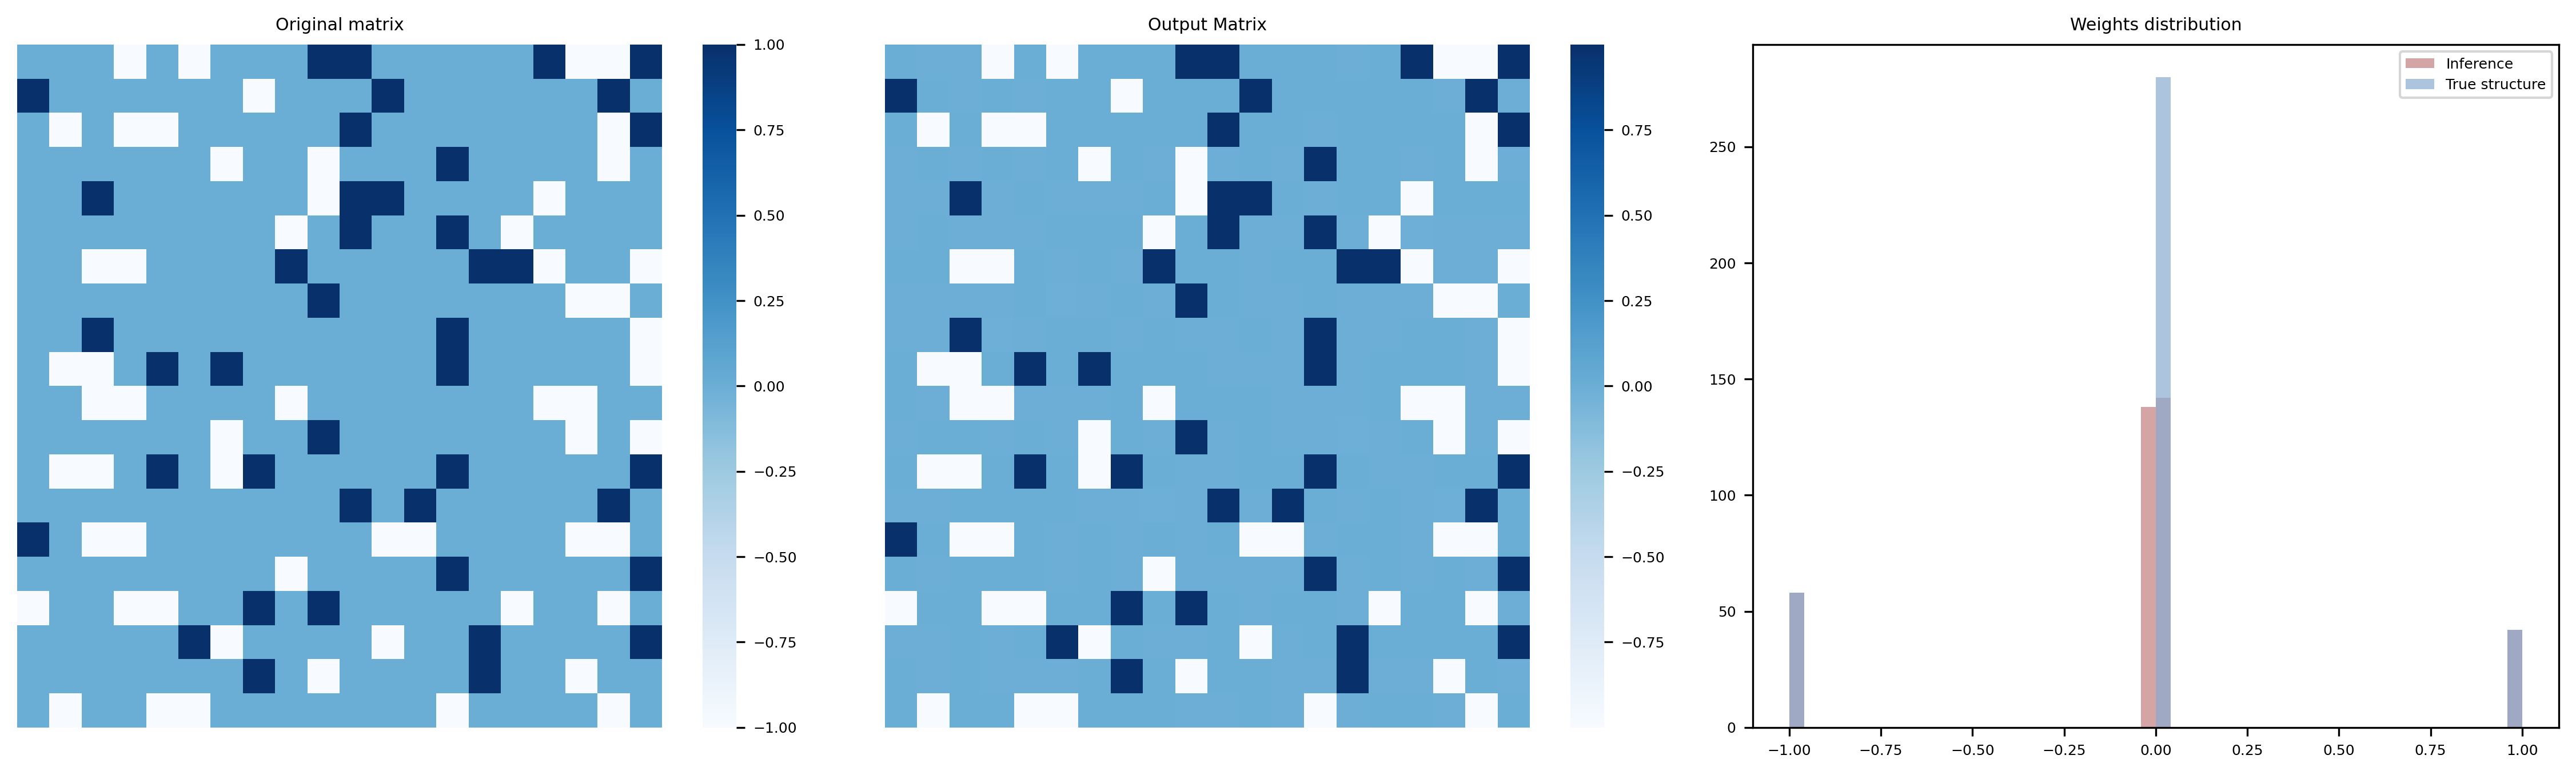

In [ ]:
Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
Gweights = (1*Gweights[:,0])+((-1)*Gweights[:,1]) #Gweights[:,0] is excitatory, Gweights[:,1] is inhibitory
Gweights = Gweights.view(-1,1).cpu()
# Gweights.cpu
bestWei = Gweights.detach().numpy()

nodes_num = args.Nodes_num
edge_num = nodes_num*(nodes_num-1)
bestWei = bestWei[:edge_num]

Stru = np.zeros((nodes_num, nodes_num))
mask = np.ones((nodes_num, nodes_num), dtype=bool)
np.fill_diagonal(mask, 0)
Stru[mask] = bestWei.squeeze()

Stru = -Stru # the edge type is opposite to the type assumptions we set
bestWei = -bestWei

selected_elements = objectAij[mask]
object_edges_rem_diag = selected_elements.reshape(-1, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
snb.heatmap(objectAij,cmap='Blues', ax=ax1)
ax1.set_title('Original matrix')
snb.heatmap(Stru, cmap='Blues', ax=ax2)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_title('Output Matrix')
plt.hist(bestWei,bins=50,alpha=0.7, color='#C17F7E', label='Inference')
plt.hist(object_edges_rem_diag,bins=50,alpha=0.7, color='#8BACD1', label='True structure')
plt.legend()
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_title('Weights distribution')

# plt.savefig('figure2/HR20nodes_inference_structure.pdf')

plt.tight_layout()
plt.show()

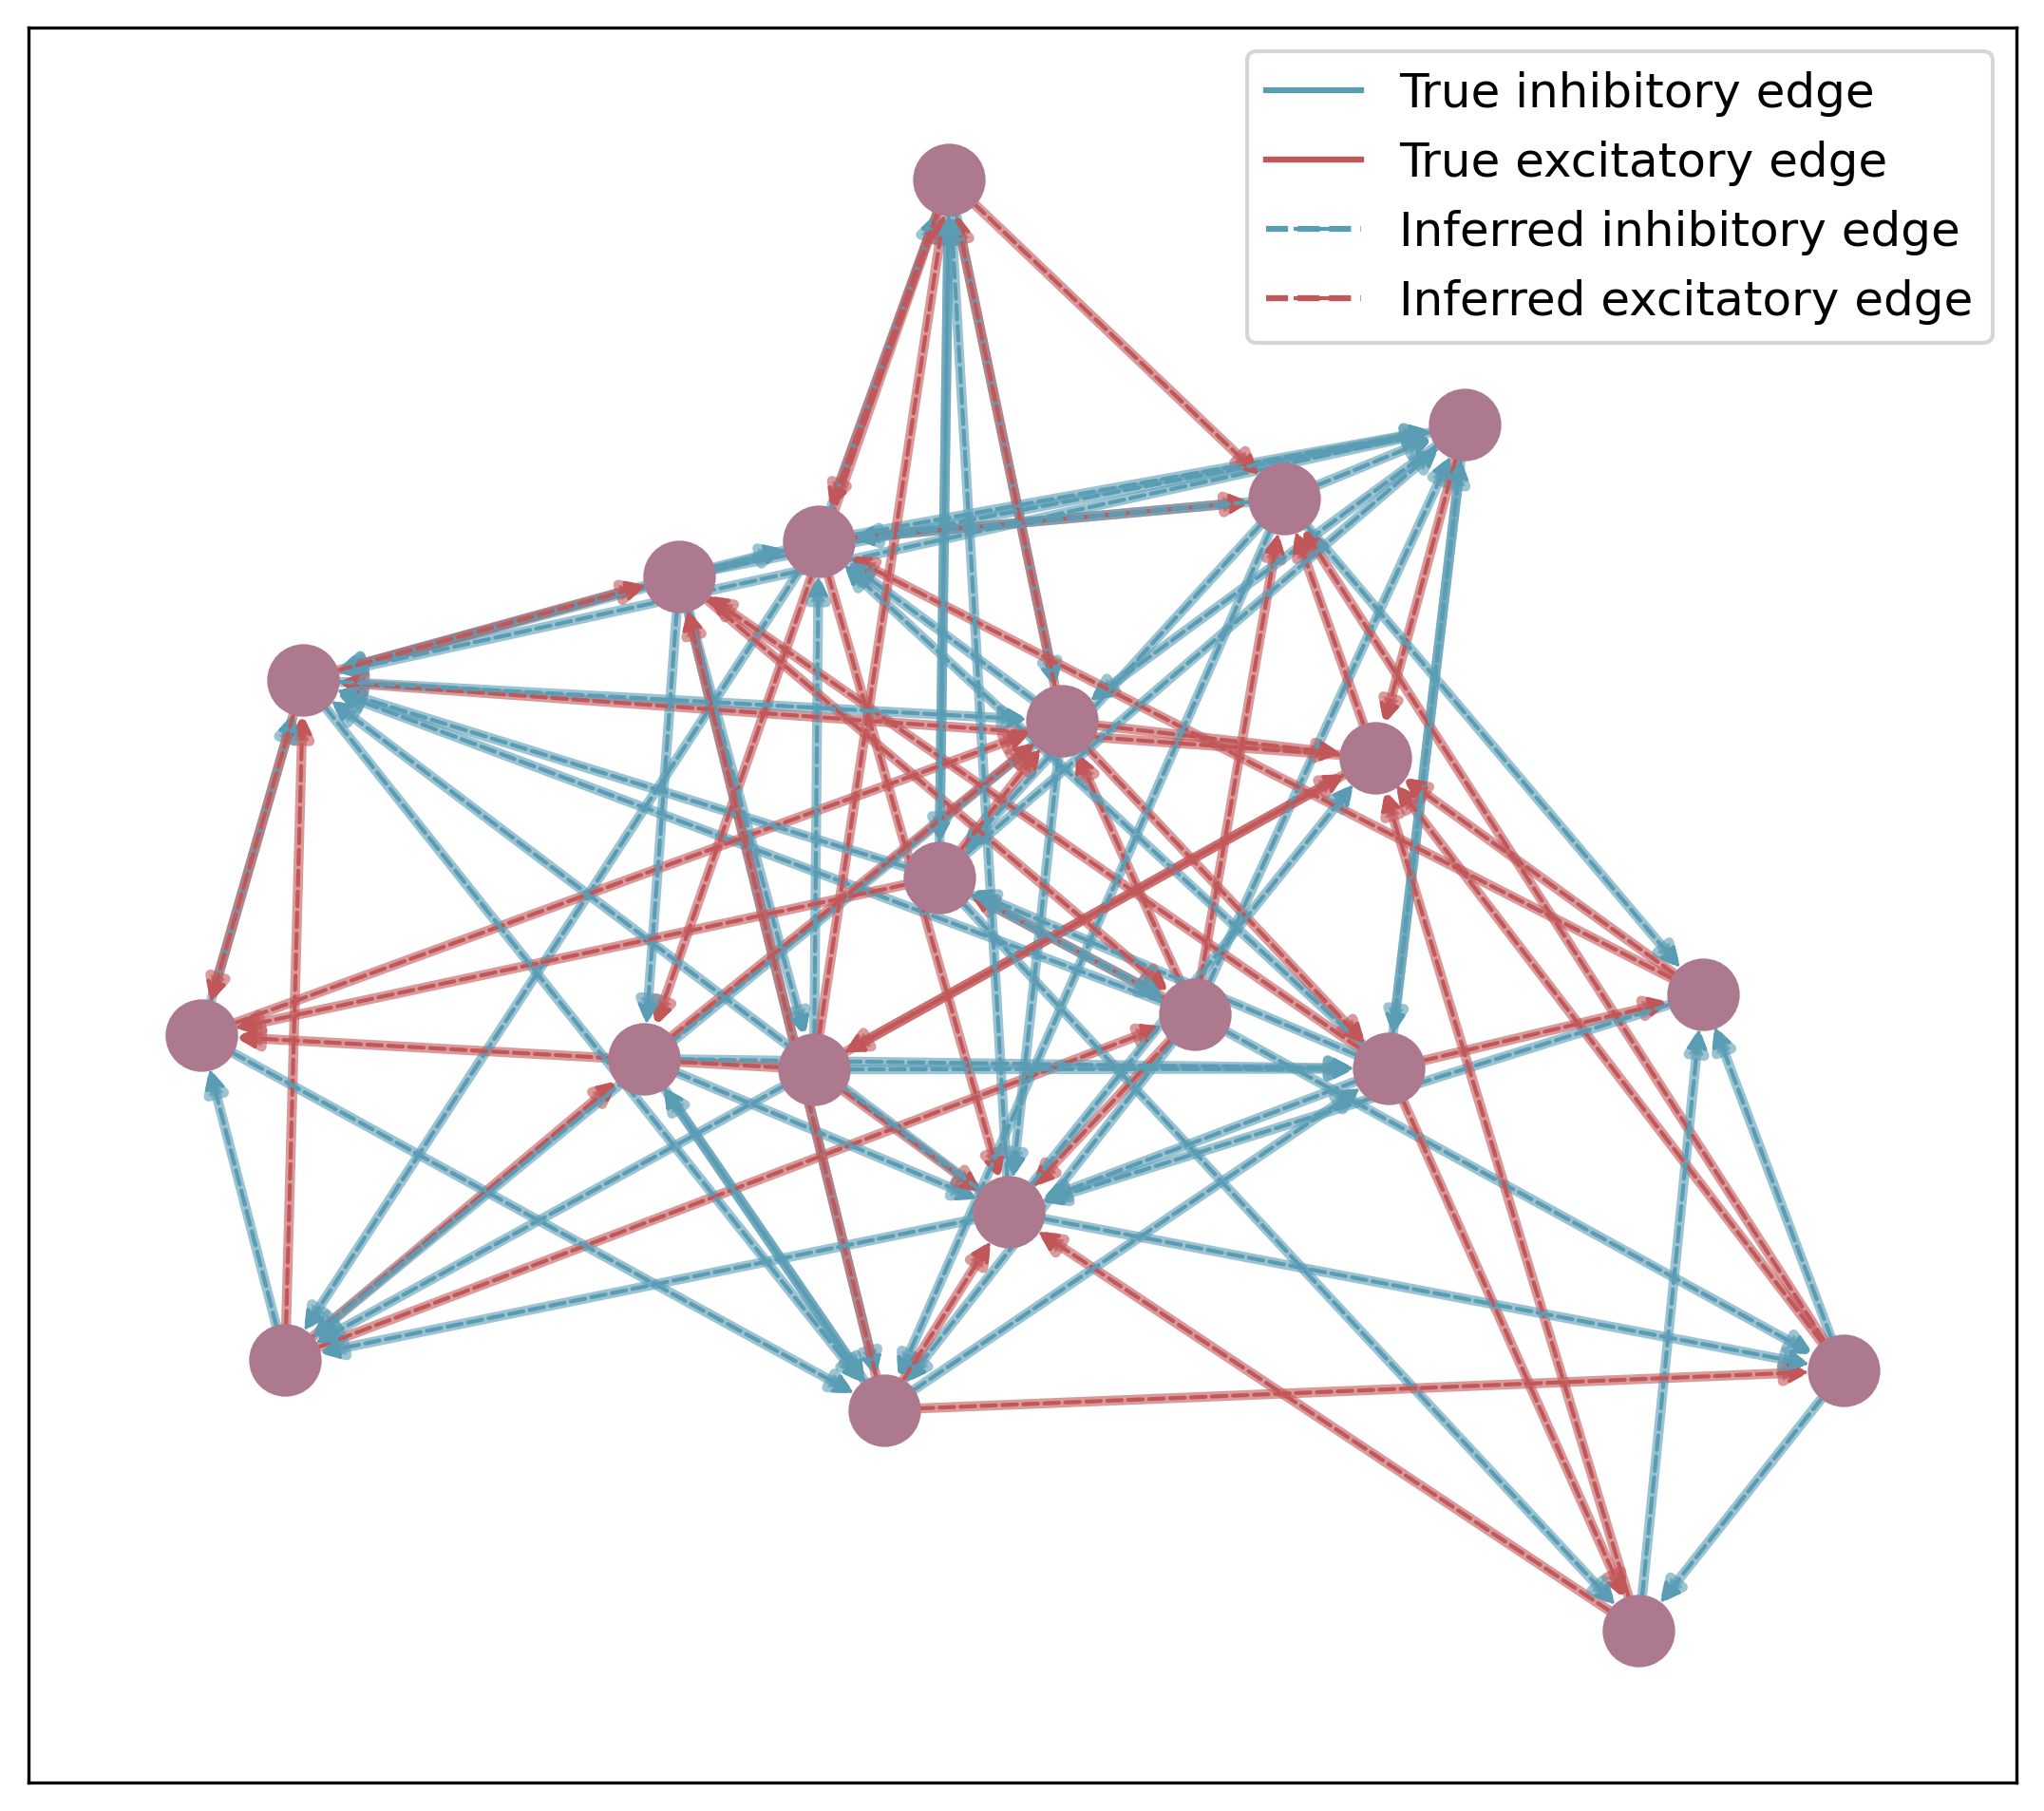

In [90]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

np.random.seed(2052)
plt.rcParams.update({'font.size': 12})  
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

fig = plt.figure(figsize=(9, 8))
G = nx.DiGraph()

palette = ['#C25759','#599CB4']
num_nodes = objectAij.shape[0]
G.add_nodes_from(range(num_nodes))

edge_colors = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if objectAij[i, j] == 1:
            G.add_edge(i, j)
            edge_colors.append('#C25759') # excitatory edges are red
        elif objectAij[i, j] == -1:
            G.add_edge(i, j)
            edge_colors.append('#599CB4') # inhibitroy edges are green

pos = nx.spring_layout(G) 
edges = G.edges(data=True)

nx.draw_networkx_nodes(G, pos, node_color='#AC798F', node_size=300)
# nx.draw_networkx_labels(G, pos, font_size=16, font_family='sans-serif')
nx.draw_networkx_edges(G, pos, width=2.5,edge_color=edge_colors,alpha=0.6,style='solid')

infer_edge_colors = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if objectAij[i, j] == 1:
            G.add_edge(i, j)
            infer_edge_colors.append('#C25759')  # excitatory edges are red
        elif objectAij[i, j] == -1:
            G.add_edge(i, j)
            infer_edge_colors.append('#599CB4')  # inhibitroy edges are green

nx.draw_networkx_edges(G, pos, width=1,edge_color=infer_edge_colors,alpha=1,style='dashed')

# create legend
true_inh = mlines.Line2D([], [], color='#599CB4', marker='_', markersize=15, label='True inhibitory edge', linestyle='solid')
true_exi = mlines.Line2D([], [], color='#C25759', marker='_', markersize=15, label='True excitatory edge', linestyle='solid')
infer_inh = mlines.Line2D([], [], color='#599CB4', marker='_', markersize=10, label='Inferred inhibitory edge', linestyle='dashed')
infer_exi = mlines.Line2D([], [], color='#C25759', marker='_', markersize=10, label='Inferred excitatory edge', linestyle='dashed')
plt.legend(handles=[true_inh, true_exi,infer_inh,infer_exi])
# plt.savefig('figure2/networkx_graph_20nodes.pdf')
plt.show()

(20, 20)


Text(0.5, 1.0, 'Structure inference error')

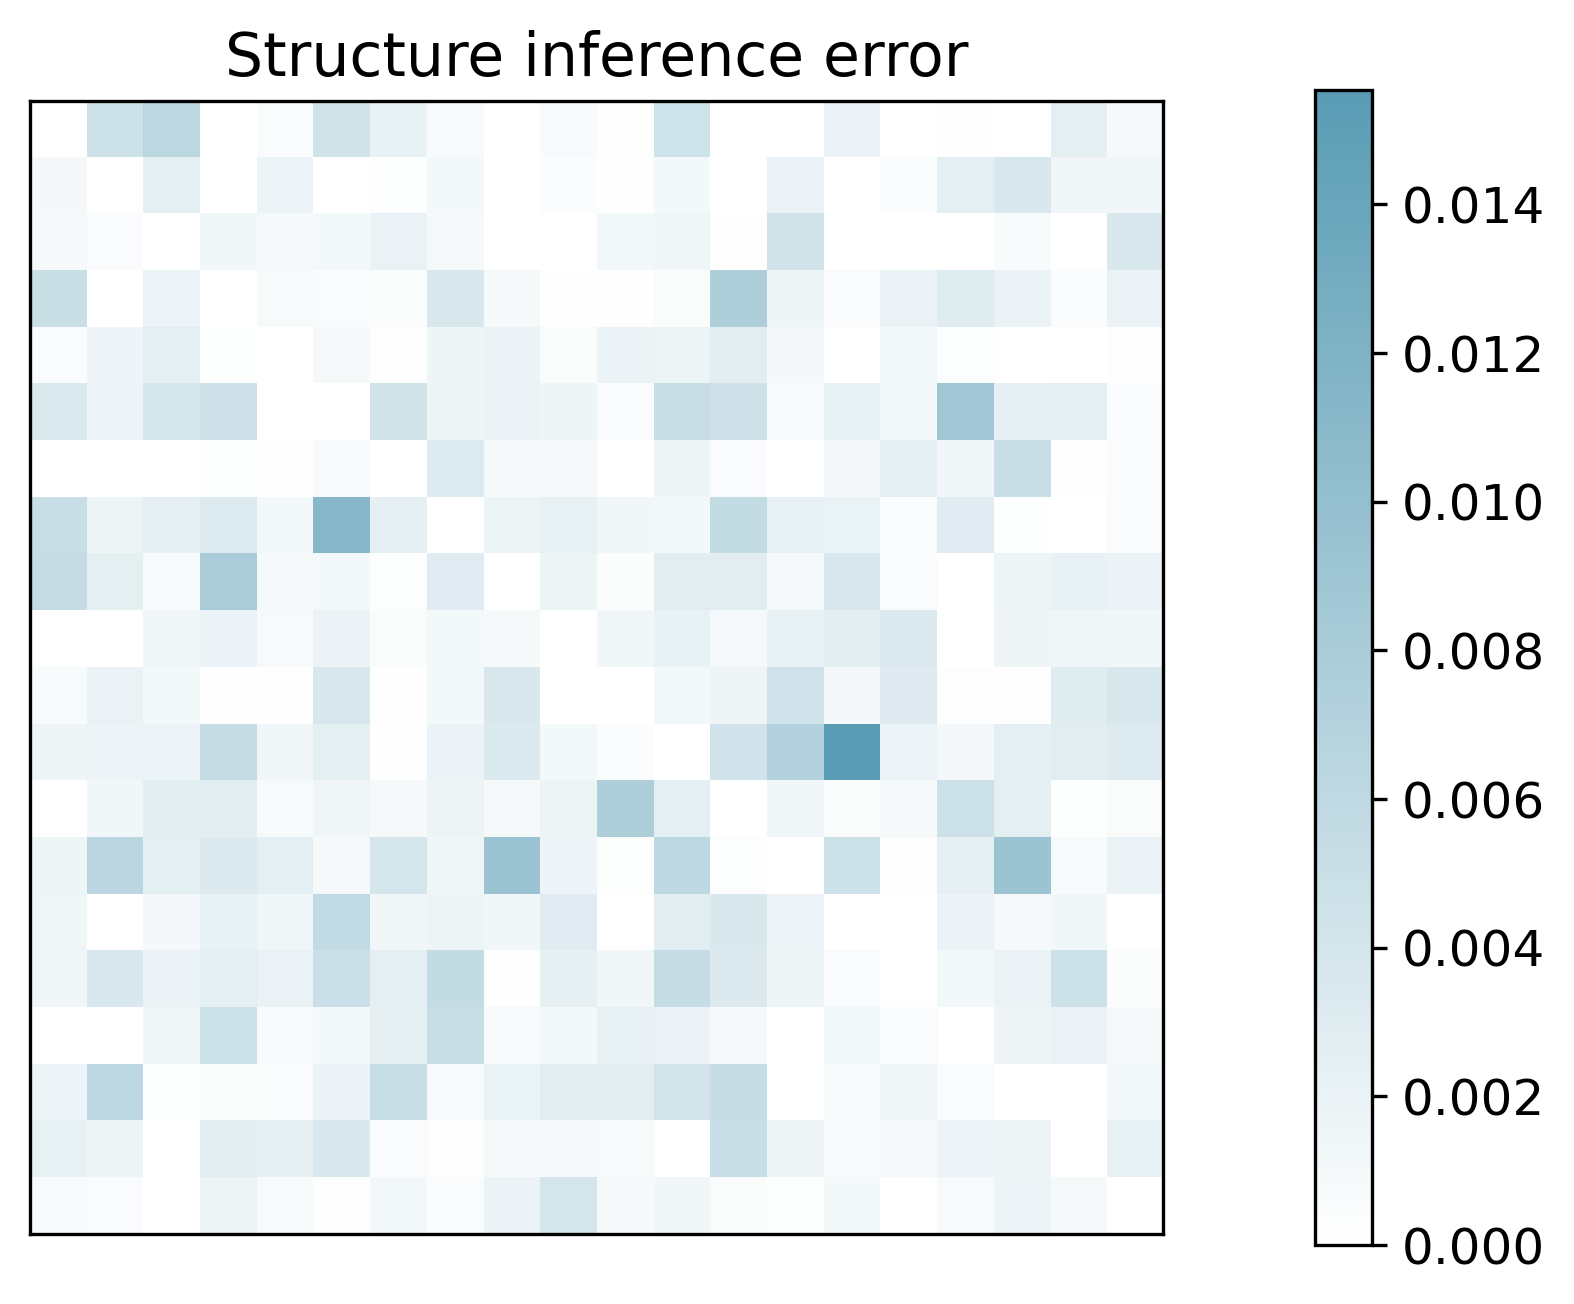

In [91]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5, 5))
struc_error = np.abs(objectAij-Stru)
# colors = ['#599CB4','#C25759'] 
colors = ['#ffffff','#599CB4'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
print(struc_error.shape)
im = plt.imshow(struc_error, cmap=cmap)
cbar = plt.colorbar(im,pad = 0.1)
plt.xticks([])
plt.yticks([])
plt.title('Structure inference error')
# plt.savefig('figure2/HR20nodes_inferror_green.pdf')

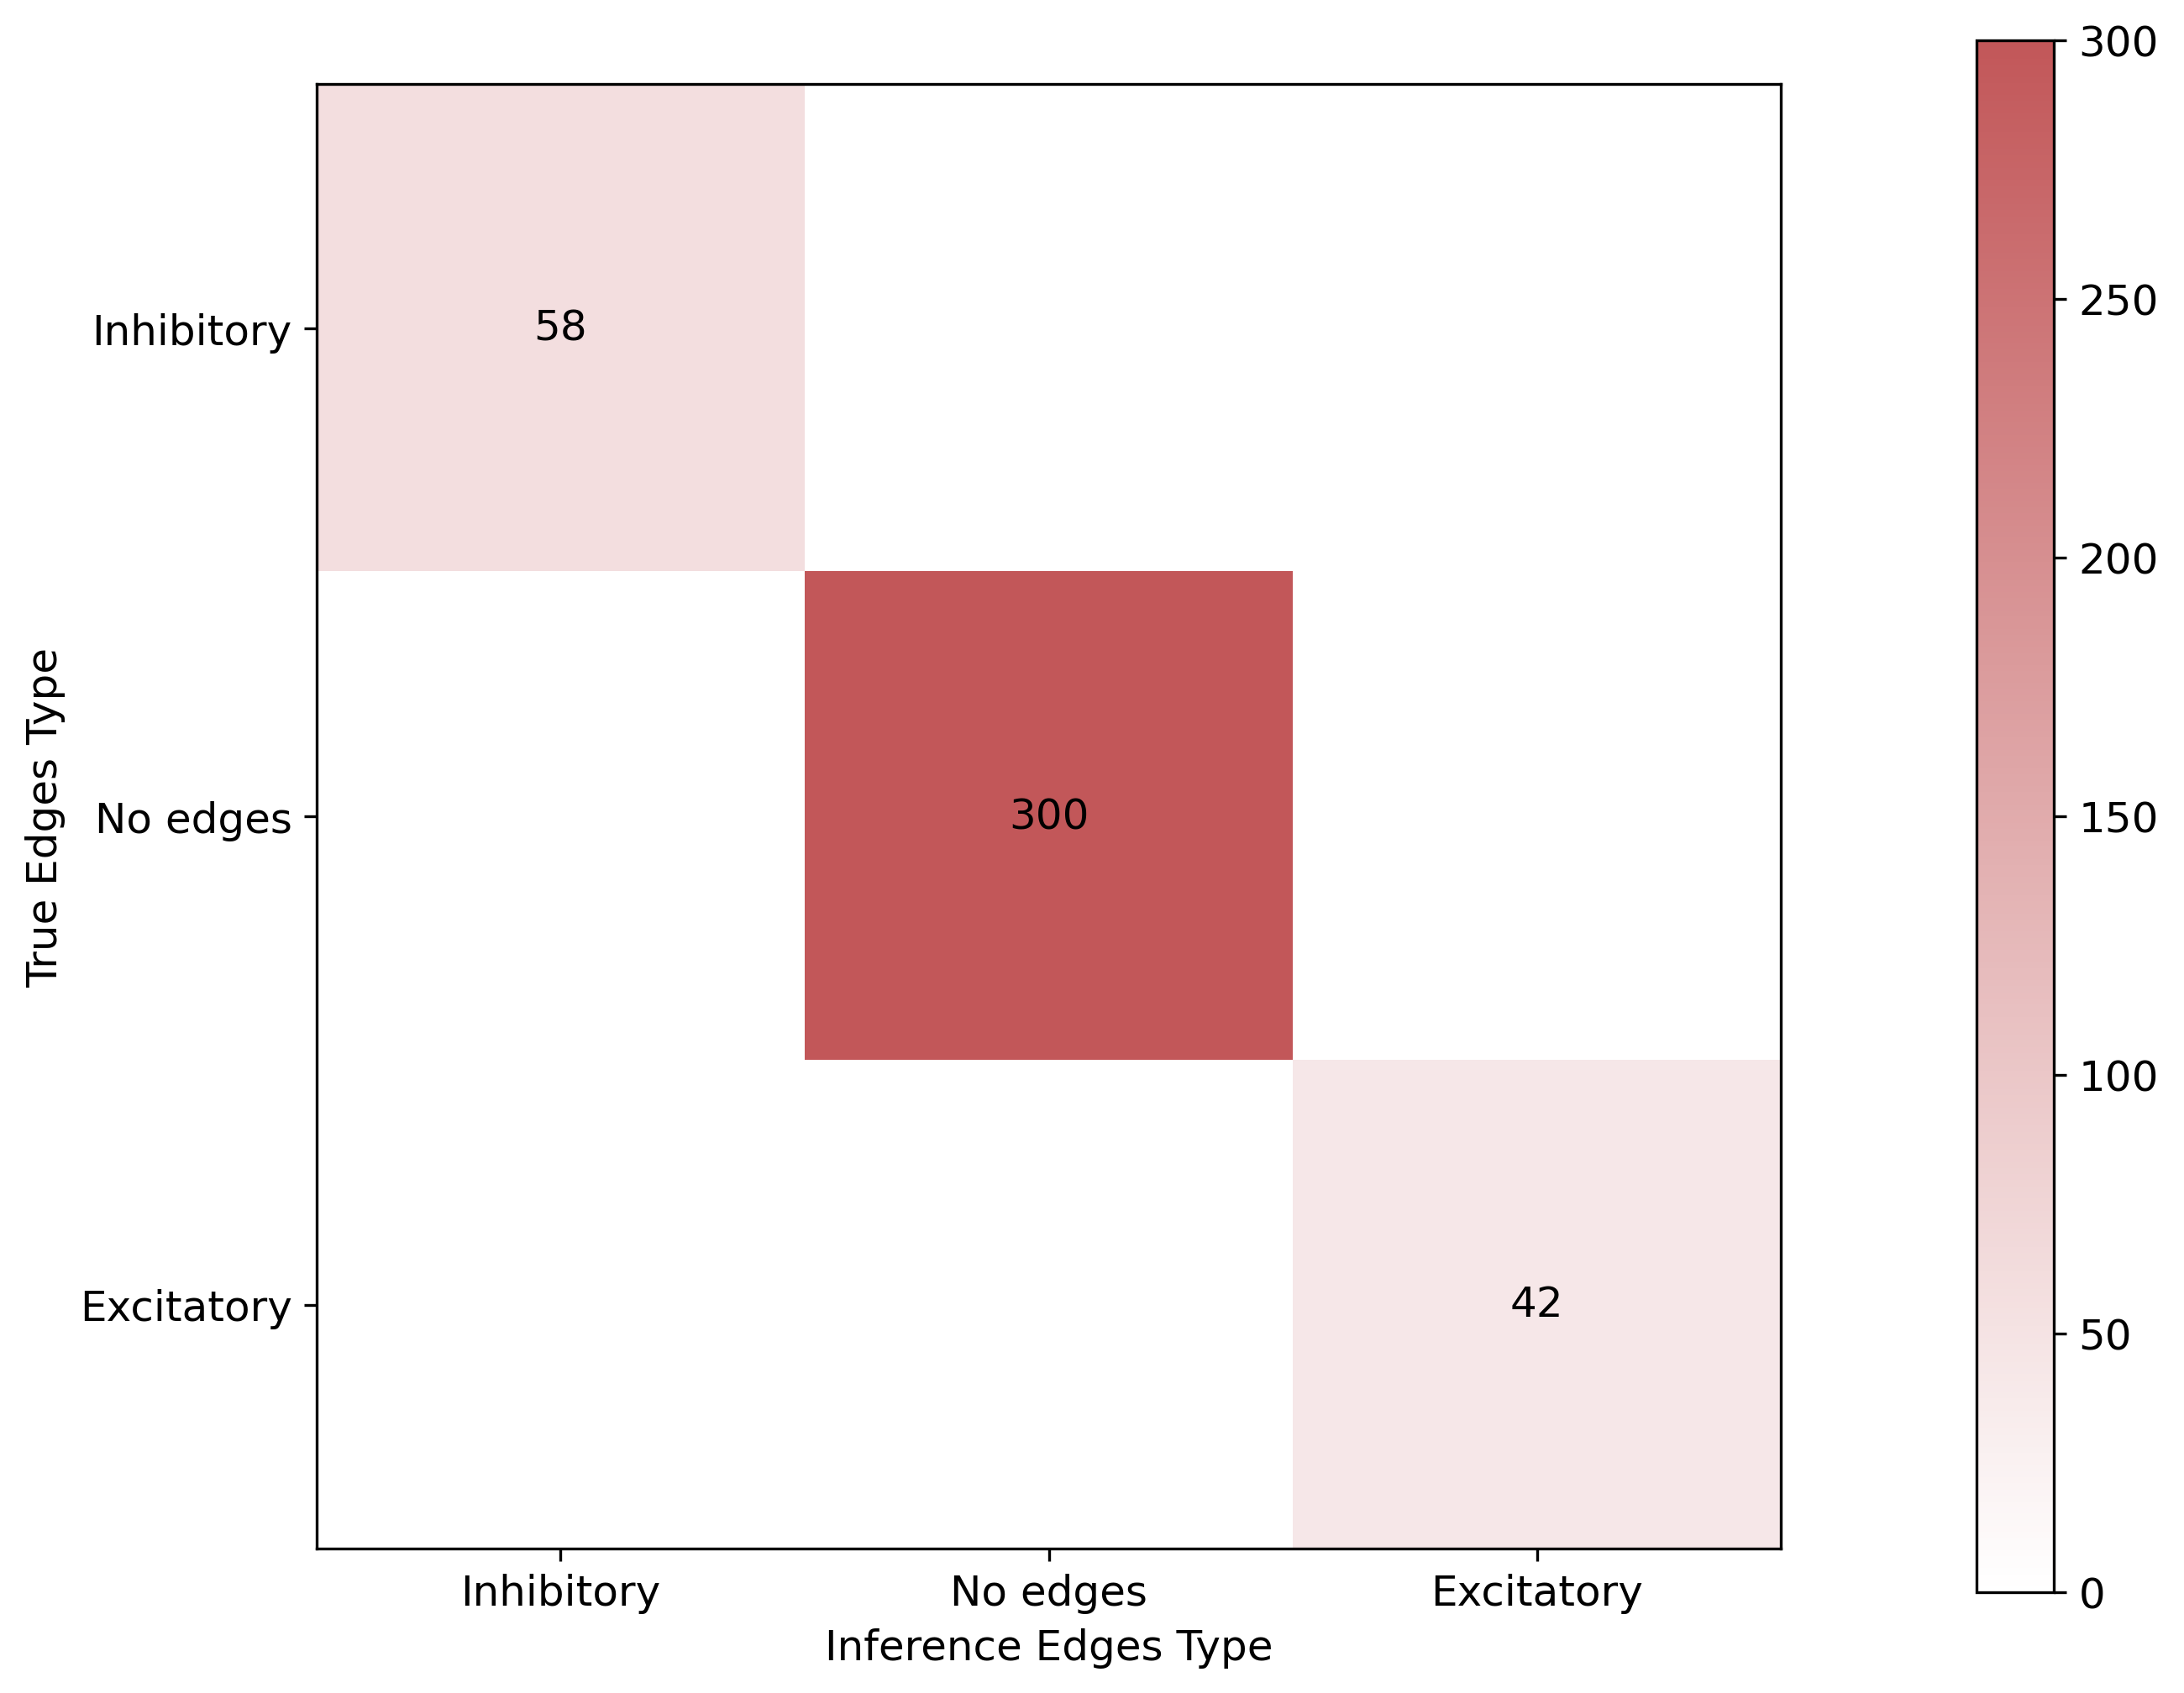

In [92]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ground_truth = objectAij.reshape(-1)
prediction = Stru.reshape(-1)

prediction_rounded = np.round(prediction)

cm = confusion_matrix(ground_truth, prediction_rounded)
colors = ['#ffffff','#C25759'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize=(10,8))
cfus = plt.imshow(cm, cmap=cmap)
cbar = plt.colorbar(cfus,pad = 0.1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i ==j :
            plt.text(j, i, f'{int(cm[i, j])}', ha='center', va='center', color='k')

plt.xticks([0., 1., 2.], ['Inhibitory','No edges','Excitatory'])
plt.yticks([0., 1., 2.], ['Inhibitory','No edges','Excitatory'])
plt.xlabel('Inference Edges Type')
plt.ylabel('True Edges Type') 
# plt.savefig('figure2/HR20nodes_confusion.pdf')
plt.show()


In this confusion matrix, the rows represent the actual edge categories, and the columns represent the inferred edge categories. The value in each cell indicates the number of times the corresponding actual edge type was inderred as the corresponding predicted edge type. Cells on the diagonal represent correct predictions, while cells off the diagonal represent incorrect predictions.